# 라벨 백테스팅
### 과연 라벨 수익률은 얼마인가? 수익률 기반으로 정확히 잘만들어졌는가?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class SimpleBacktester:
    def __init__(self, data_path, start_date='2004-01-01', end_date='2014-12-31'):
        """
        3단계 라벨용 개별 종목 백테스터
        
        Parameters:
        -----------
        data_path : str
            CSV 파일들이 저장된 경로
        start_date : str
            백테스팅 시작 날짜
        end_date : str
            백테스팅 종료 날짜
        """
        self.data_path = data_path
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.stocks_data = {}
        self.results = {}
        
    def load_data(self):
        """CSV 파일들 로딩 (유연하게)"""
        # 다양한 패턴 시도 (최적화 라벨 파일 우선)
        patterns = ["*_optimized.csv", "*_enhanced.csv", "*_cleaned.csv", "*.csv"]
        csv_files = []
        
        for pattern in patterns:
            files = glob.glob(os.path.join(self.data_path, pattern))
            if files:
                csv_files = files
                print(f"파일 패턴 발견: {pattern} ({len(files)}개)")
                break
        
        if not csv_files:
            raise FileNotFoundError(f"CSV 파일을 찾을 수 없습니다: {self.data_path}")
        
        print(f"CSV 파일 로딩 중... ({len(csv_files)}개)")
        
        for file_path in tqdm(csv_files):
            try:
                # 파일명에서 종목명 추출
                filename = os.path.basename(file_path)
                symbol = filename.replace('.csv', '')
                for suffix in ['_enhanced', '_cleaned', '_processed']:
                    symbol = symbol.replace(suffix, '')
                
                # CSV 읽기
                df = pd.read_csv(file_path)
                
                # 날짜 컬럼 처리
                if 'Date' in df.columns:
                    df['Date'] = pd.to_datetime(df['Date'])
                    df.set_index('Date', inplace=True)
                elif 'Unnamed: 0' in df.columns:
                    df['Date'] = pd.to_datetime(df['Unnamed: 0'])
                    df.set_index('Date', inplace=True)
                    df.drop('Unnamed: 0', axis=1, inplace=True)
                else:
                    df.index = pd.to_datetime(df.index)
                
                # 사용할 라벨 컬럼 결정 (우선순위: Optimized_Label > Label)
                if 'Optimized_Label' in df.columns:
                    label_col = 'Optimized_Label'
                    label_name_col = 'Optimized_Label_Name'
                elif 'Label' in df.columns:
                    label_col = 'Label'
                    label_name_col = 'Label_Name'
                else:
                    continue
                
                # 필수 컬럼 확인
                if not all(col in df.columns for col in ['Close', label_col]):
                    continue
                
                # Label_Name이 없으면 3단계 라벨맵으로 생성
                if label_name_col not in df.columns:
                    label_map = {0: 'Strong_Sell', 1: 'Hold', 2: 'Strong_Buy'}
                    df[label_name_col] = df[label_col].map(label_map)
                
                # 백테스트에서 사용할 표준 컬럼명으로 복사
                df['Label'] = df[label_col]
                df['Label_Name'] = df[label_name_col]
                
                # 날짜 범위 필터링
                df = df.loc[self.start_date:self.end_date]
                
                if len(df) > 100:
                    self.stocks_data[symbol] = df
                    
            except Exception as e:
                print(f"파일 로딩 실패: {filename} - {e}")
        
        print(f"로딩 완료: {len(self.stocks_data)}개 종목")
        return self.stocks_data
    
    def simulate_trading(self, symbol, initial_capital=10000, transaction_cost=0.001):
        """3단계 라벨 기반 매매 시뮬레이션"""
        
        df = self.stocks_data[symbol].copy()
        
        # 시뮬레이션 변수
        cash = initial_capital
        shares = 0
        portfolio_values = []
        trades = []
        position = 'CASH'  # CASH, LONG
        
        for date, row in df.iterrows():
            current_price = row['Close']
            label = row['Label']
            label_name = row['Label_Name']
            
            # 포트폴리오 가치 계산
            portfolio_value = cash + (shares * current_price)
            portfolio_values.append(portfolio_value)
            
            # 3단계 라벨에 따른 매매 신호 처리
            if label == 2 and position == 'CASH':  # Strong_Buy (라벨=2) 신호
                shares_to_buy = cash / (current_price * (1 + transaction_cost))
                if shares_to_buy > 0:
                    shares += shares_to_buy
                    cash -= shares_to_buy * current_price * (1 + transaction_cost)
                    position = 'LONG'
                    
                    trades.append({
                        'date': date,
                        'action': 'BUY',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'value': shares_to_buy * current_price,
                        'label': label_name
                    })
            
            elif label == 0 and position == 'LONG':  # Strong_Sell (라벨=0) 신호
                if shares > 0:
                    sale_value = shares * current_price * (1 - transaction_cost)
                    cash += sale_value
                    
                    trades.append({
                        'date': date,
                        'action': 'SELL',
                        'price': current_price,
                        'shares': shares,
                        'value': sale_value,
                        'label': label_name
                    })
                    
                    shares = 0
                    position = 'CASH'
            
            # Hold (라벨=1)일 때는 기존 포지션 유지
        
        # 최종 정산 (보유주식 강제 매도)
        if shares > 0:
            final_price = df.iloc[-1]['Close']
            final_value = shares * final_price * (1 - transaction_cost)
            cash += final_value
            
            trades.append({
                'date': df.index[-1],
                'action': 'FINAL_SELL',
                'price': final_price,
                'shares': shares,
                'value': final_value,
                'label': 'FINAL'
            })
        
        # 결과 계산
        df['Portfolio_Value'] = portfolio_values
        final_value = cash
        total_return = (final_value - initial_capital) / initial_capital
        
        # Buy & Hold: 첫날 매수해서 마지막날 매도
        buy_hold_return = (df.iloc[-1]['Close'] - df.iloc[0]['Close']) / df.iloc[0]['Close']
        
        # 샤프 비율: (평균 일일수익률 / 수익률 변동성) × √252
        daily_returns = df['Portfolio_Value'].pct_change().dropna()
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
        
        # 최대 손실폭 (Maximum Drawdown)
        peak = df['Portfolio_Value'].expanding().max()
        drawdown = (df['Portfolio_Value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        # 승률 계산 (매매당 수익률)
        trade_returns = []
        for i in range(0, len(trades)-1, 2):  # 매수-매도 쌍으로 계산
            if i+1 < len(trades):
                buy_trade = trades[i]
                sell_trade = trades[i+1]
                trade_return = (sell_trade['price'] - buy_trade['price']) / buy_trade['price']
                trade_returns.append(trade_return)
        
        win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns) if trade_returns else 0
        avg_trade_return = np.mean(trade_returns) if trade_returns else 0
        
        return {
            'symbol': symbol,
            'initial_capital': initial_capital,
            'final_value': final_value,
            'total_return': total_return,
            'buy_hold_return': buy_hold_return,
            'excess_return': total_return - buy_hold_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'avg_trade_return': avg_trade_return,
            'trades': trades,
            'portfolio_values': df['Portfolio_Value'].values,
            'dates': df.index.values
        }
    
    def plot_individual_stock(self, symbol, figsize=(15, 10)):
        """개별 종목 백테스팅 결과 시각화 (3단계 라벨용)"""
        
        if symbol not in self.results:
            print(f"{symbol} 결과가 없습니다.")
            return
        
        result = self.results[symbol]
        df = self.stocks_data[symbol]
        
        fig, axes = plt.subplots(3, 1, figsize=figsize)
        
        # 1. 가격 차트 + 매매 신호
        ax1 = axes[0]
        ax1.plot(df.index, df['Close'], label='Close Price', alpha=0.7, color='black')
        
        # 매매 포인트 표시
        trades = result['trades']
        buy_trades = [t for t in trades if t['action'] == 'BUY']
        sell_trades = [t for t in trades if t['action'] in ['SELL', 'FINAL_SELL']]
        
        if buy_trades:
            buy_dates = [t['date'] for t in buy_trades]
            buy_prices = [t['price'] for t in buy_trades]
            ax1.scatter(buy_dates, buy_prices, color='green', marker='^', 
                       s=100, label=f'Buy Signals ({len(buy_trades)})', zorder=5)
        
        if sell_trades:
            sell_dates = [t['date'] for t in sell_trades]
            sell_prices = [t['price'] for t in sell_trades]
            ax1.scatter(sell_dates, sell_prices, color='red', marker='v', 
                       s=100, label=f'Sell Signals ({len(sell_trades)})', zorder=5)
        
        ax1.set_title(f'{symbol} - Price & Trading Signals')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # X축 월 단위로 설정
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. 포트폴리오 가치 vs Buy & Hold 비교
        ax2 = axes[1]
        ax2.plot(df.index, result['portfolio_values'], label='Strategy Portfolio', color='blue', linewidth=2)
        
        # Buy & Hold 비교 (첫날 매수 → 마지막날 매도)
        buy_hold_values = (df['Close'] / df.iloc[0]['Close']) * result['initial_capital']
        ax2.plot(df.index, buy_hold_values, label='Buy & Hold', color='orange', alpha=0.7)
        
        ax2.set_title(f'Portfolio Value Comparison')
        ax2.set_ylabel('Portfolio Value ($)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # X축 월 단위로 설정
        ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax2.tick_params(axis='x', rotation=45)
        
        # 3. 라벨 분포 (3단계)
        ax3 = axes[2]
        label_counts = df['Label'].value_counts().sort_index()
        
        # 3단계 라벨명과 색상
        label_names = {0: 'Strong_Sell', 1: 'Hold', 2: 'Strong_Buy'}
        colors = {0: 'red', 1: 'gray', 2: 'green'}
        
        # 막대 그래프
        labels_present = label_counts.index
        bar_colors = [colors[i] for i in labels_present]
        bar_labels = [label_names[i] for i in labels_present]
        
        bars = ax3.bar(range(len(label_counts)), label_counts.values, color=bar_colors)
        ax3.set_title('Label Distribution (3-Class)')
        ax3.set_xlabel('Signal Types')
        ax3.set_ylabel('Count')
        ax3.set_xticks(range(len(label_counts)))
        ax3.set_xticklabels(bar_labels)
        
        # 막대 위에 숫자 표시
        for i, count in enumerate(label_counts.values):
            ax3.text(i, count + 0.01*max(label_counts), str(count), 
                    ha='center', va='bottom')
        
        plt.tight_layout()
        
        # 결과 요약 출력
        print(f"\n{symbol} 백테스팅 결과:")
        print(f"전략 수익률: {result['total_return']:.2%}")
        print(f"Buy & Hold 수익률: {result['buy_hold_return']:.2%}")
        print(f"초과 수익률: {result['excess_return']:.2%}")
        print(f"샤프 비율: {result['sharpe_ratio']:.2f}")
        print(f"최대 손실폭: {result['max_drawdown']:.2%}")
        print(f"총 거래 횟수: {result['num_trades']}회")
        print(f"승률: {result['win_rate']:.2%}")
        print(f"평균 거래수익률: {result['avg_trade_return']:.2%}")
        print(f"최종 자산: ${result['final_value']:,.0f}")
        
        plt.show()
    
    def get_summary_stats(self):
        """전체 백테스팅 결과 요약"""
        if not self.results:
            return
        
        summary_data = []
        for symbol, result in self.results.items():
            summary_data.append({
                'Symbol': symbol,
                'Total_Return': result['total_return'],
                'Excess_Return': result['excess_return'],
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Win_Rate': result['win_rate'],
                'Num_Trades': result['num_trades']
            })
        
        summary_df = pd.DataFrame(summary_data)
        print("\n전체 백테스팅 결과 요약:")
        print("="*60)
        print(summary_df.to_string(index=False, float_format='%.3f'))
        
        # 평균 통계
        print(f"\n평균 통계:")
        print(f"평균 수익률: {summary_df['Total_Return'].mean():.2%}")
        print(f"평균 초과수익률: {summary_df['Excess_Return'].mean():.2%}")
        print(f"평균 샤프비율: {summary_df['Sharpe_Ratio'].mean():.2f}")
        print(f"평균 승률: {summary_df['Win_Rate'].mean():.2%}")
        
        return summary_df

def run_individual_backtest(data_path, start_date='2004-01-01', end_date='2014-12-31', 
                           symbols=None, max_stocks=5, initial_capital=10000):
    """
    3단계 라벨 기반 개별 종목 백테스팅 실행
    
    Parameters:
    -----------
    data_path : str
        CSV 파일 경로
    start_date : str
        백테스팅 시작 날짜
    end_date : str
        백테스팅 종료 날짜
    symbols : list, optional
        특정 종목만 테스트 (None이면 전체 또는 처음 몇 개)
    max_stocks : int
        최대 테스트 종목 수
    initial_capital : float
        초기 투자 금액
    """
    
    # 백테스터 생성 (기간 설정 포함)
    backtester = SimpleBacktester(data_path, start_date, end_date)
    
    # 데이터 로딩
    backtester.load_data()
    
    # 테스트할 종목 선택
    if symbols:
        stocks_to_test = [s for s in symbols if s in backtester.stocks_data]
    else:
        stocks_to_test = list(backtester.stocks_data.keys())[:max_stocks]
    
    print(f"\nBacktesting Period: {start_date} to {end_date}")
    print(f"Initial Capital: ${initial_capital:,}")
    print(f"3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)")
    print(f"Running backtest for {len(stocks_to_test)} stocks...")
    
    # 각 종목별 백테스팅 및 시각화
    for symbol in stocks_to_test:
        result = backtester.simulate_trading(symbol, initial_capital)
        if result:
            backtester.results[symbol] = result
            backtester.plot_individual_stock(symbol)
    
    # 전체 결과 요약
    summary_df = backtester.get_summary_stats()
    
    return backtester, summary_df

# 종목별 기간 백테스팅

파일 패턴 발견: *_optimized.csv (100개)
CSV 파일 로딩 중... (100개)


100%|██████████| 100/100 [00:11<00:00,  8.84it/s]


로딩 완료: 100개 종목

Backtesting Period: 2015-01-01 to 2025-12-31
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 10 stocks...

1INCH_optimized 백테스팅 결과:
전략 수익률: 76633715068.27%
Buy & Hold 수익률: -88.66%
초과 수익률: 76633715156.93%
샤프 비율: 4.91
최대 손실폭: -25.81%
총 거래 횟수: 270회
승률: 99.26%
평균 거래수익률: 19.70%
최종 자산: $7,663,371,516,827


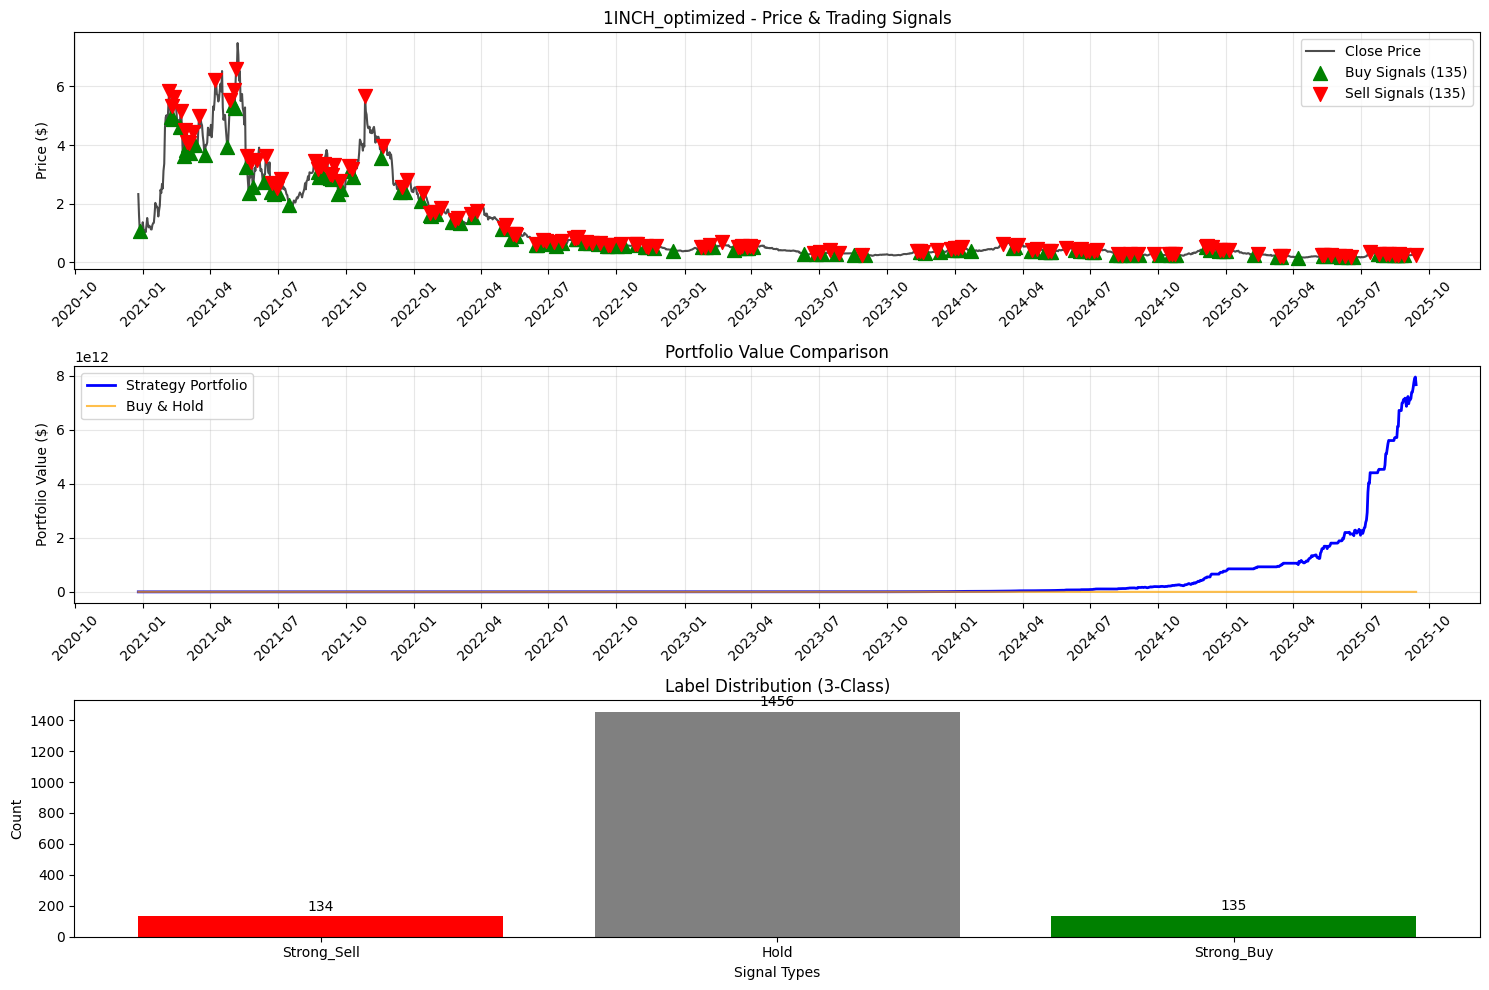


AAVE_optimized 백테스팅 결과:
전략 수익률: 104401076429000.78%
Buy & Hold 수익률: 59244.53%
초과 수익률: 104401076369756.25%
샤프 비율: 0.46
최대 손실폭: -33.52%
총 거래 횟수: 260회
승률: 100.00%
평균 거래수익률: 106.01%
최종 자산: $10,440,107,642,910,078


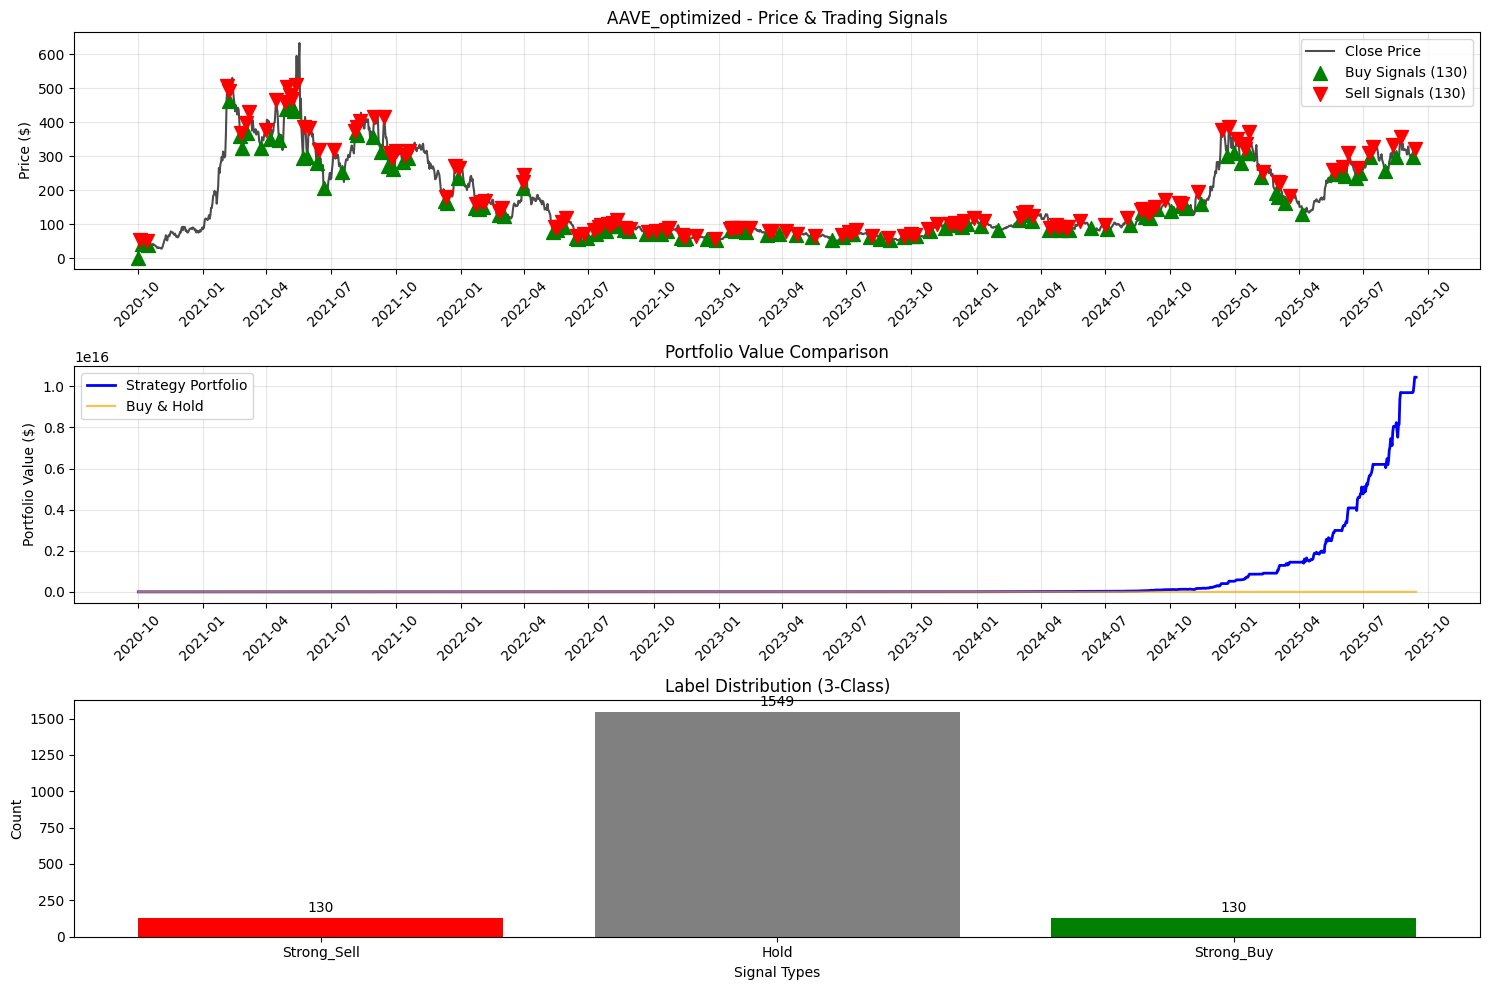


ADA_optimized 백테스팅 결과:
전략 수익률: 22981348292891288.00%
Buy & Hold 수익률: 2673.50%
초과 수익률: 22981348292888612.00%
샤프 비율: 3.68
최대 손실폭: -38.79%
총 거래 횟수: 336회
승률: 99.40%
평균 거래수익률: 37.78%
최종 자산: $2,298,134,829,289,138,688


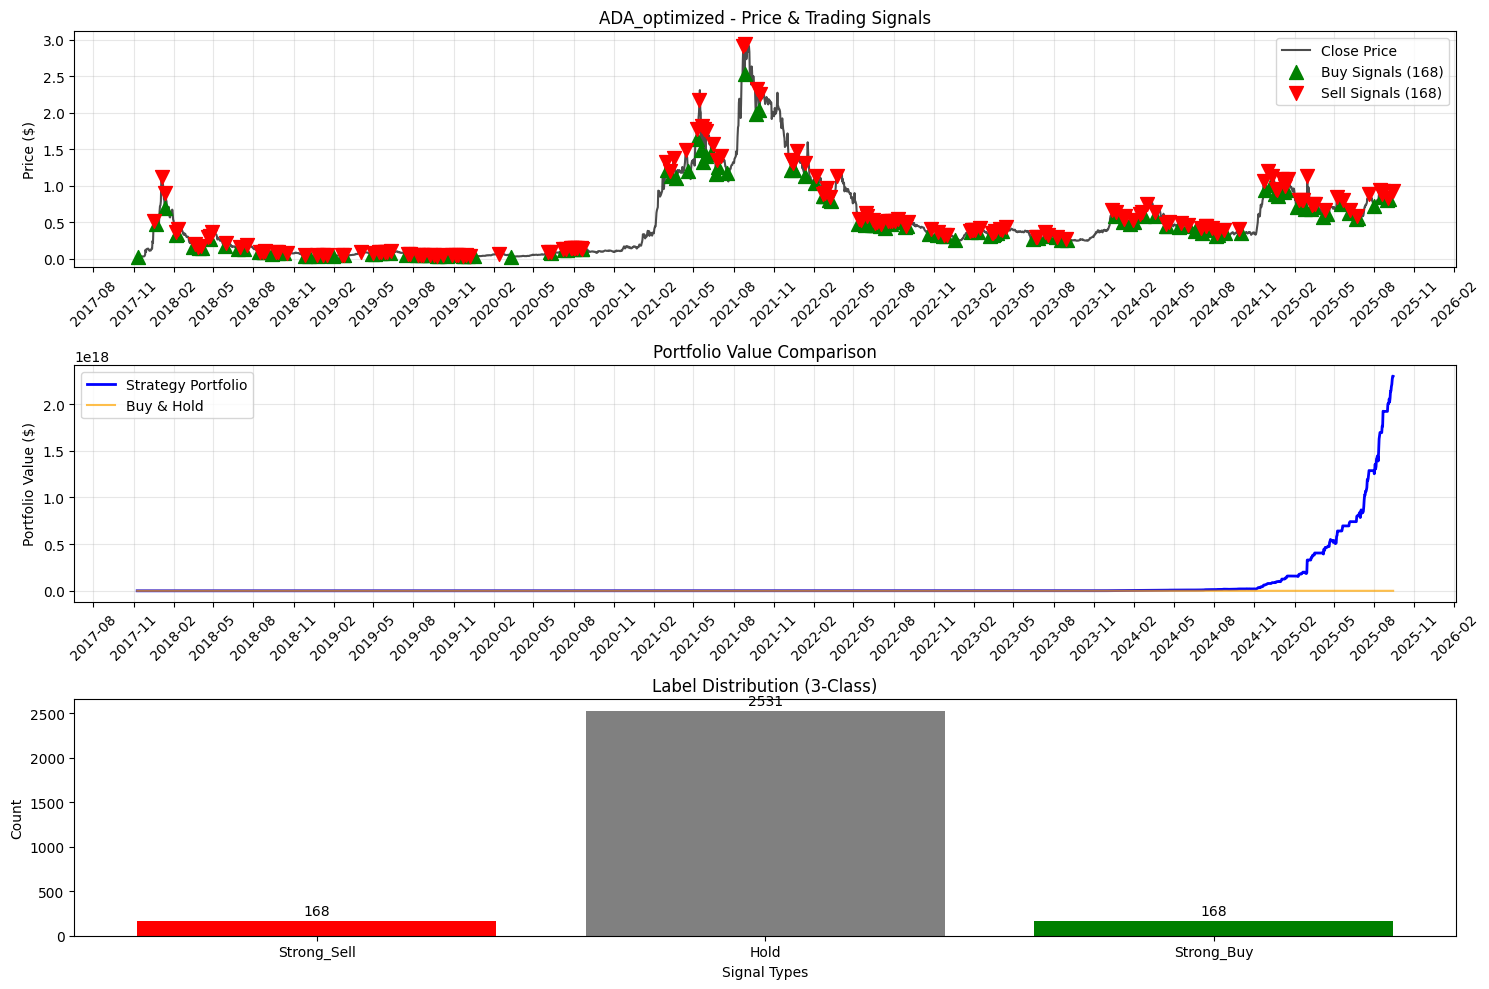


ALGO_optimized 백테스팅 결과:
전략 수익률: 32835524791502.01%
Buy & Hold 수익률: -92.52%
초과 수익률: 32835524791594.52%
샤프 비율: 4.71
최대 손실폭: -26.37%
총 거래 횟수: 308회
승률: 100.00%
평균 거래수익률: 22.93%
최종 자산: $3,283,552,479,160,201


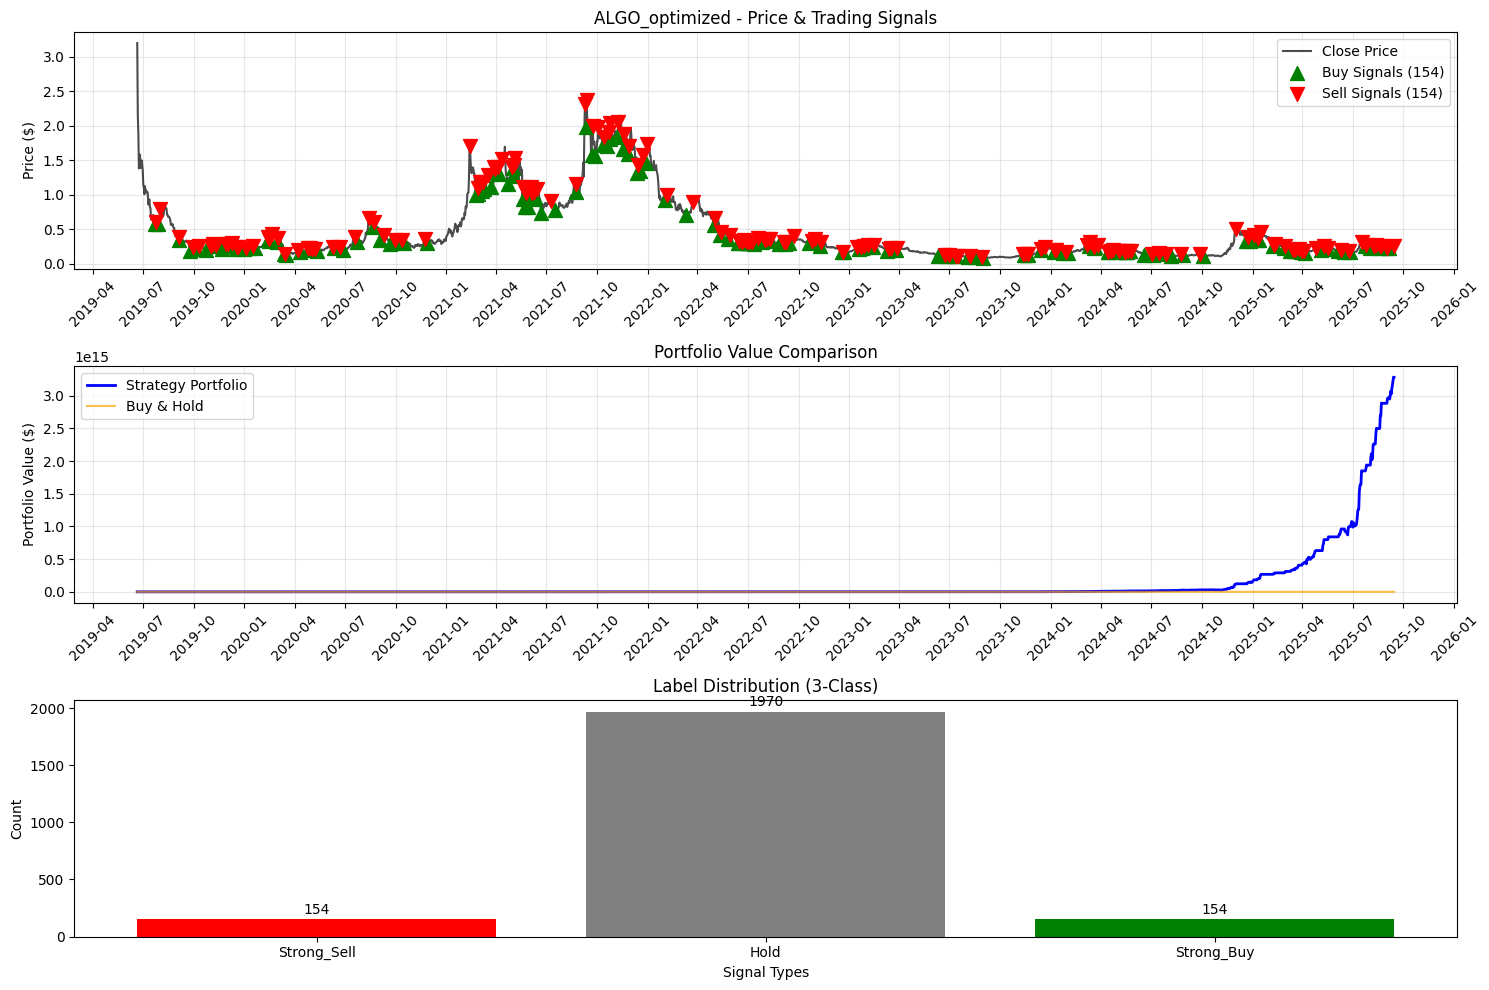


ANKR_optimized 백테스팅 결과:
전략 수익률: 119997193053103.16%
Buy & Hold 수익률: 14.63%
초과 수익률: 119997193053088.53%
샤프 비율: 4.14
최대 손실폭: -39.05%
총 거래 횟수: 280회
승률: 100.00%
평균 거래수익률: 40.71%
최종 자산: $11,999,719,305,320,316


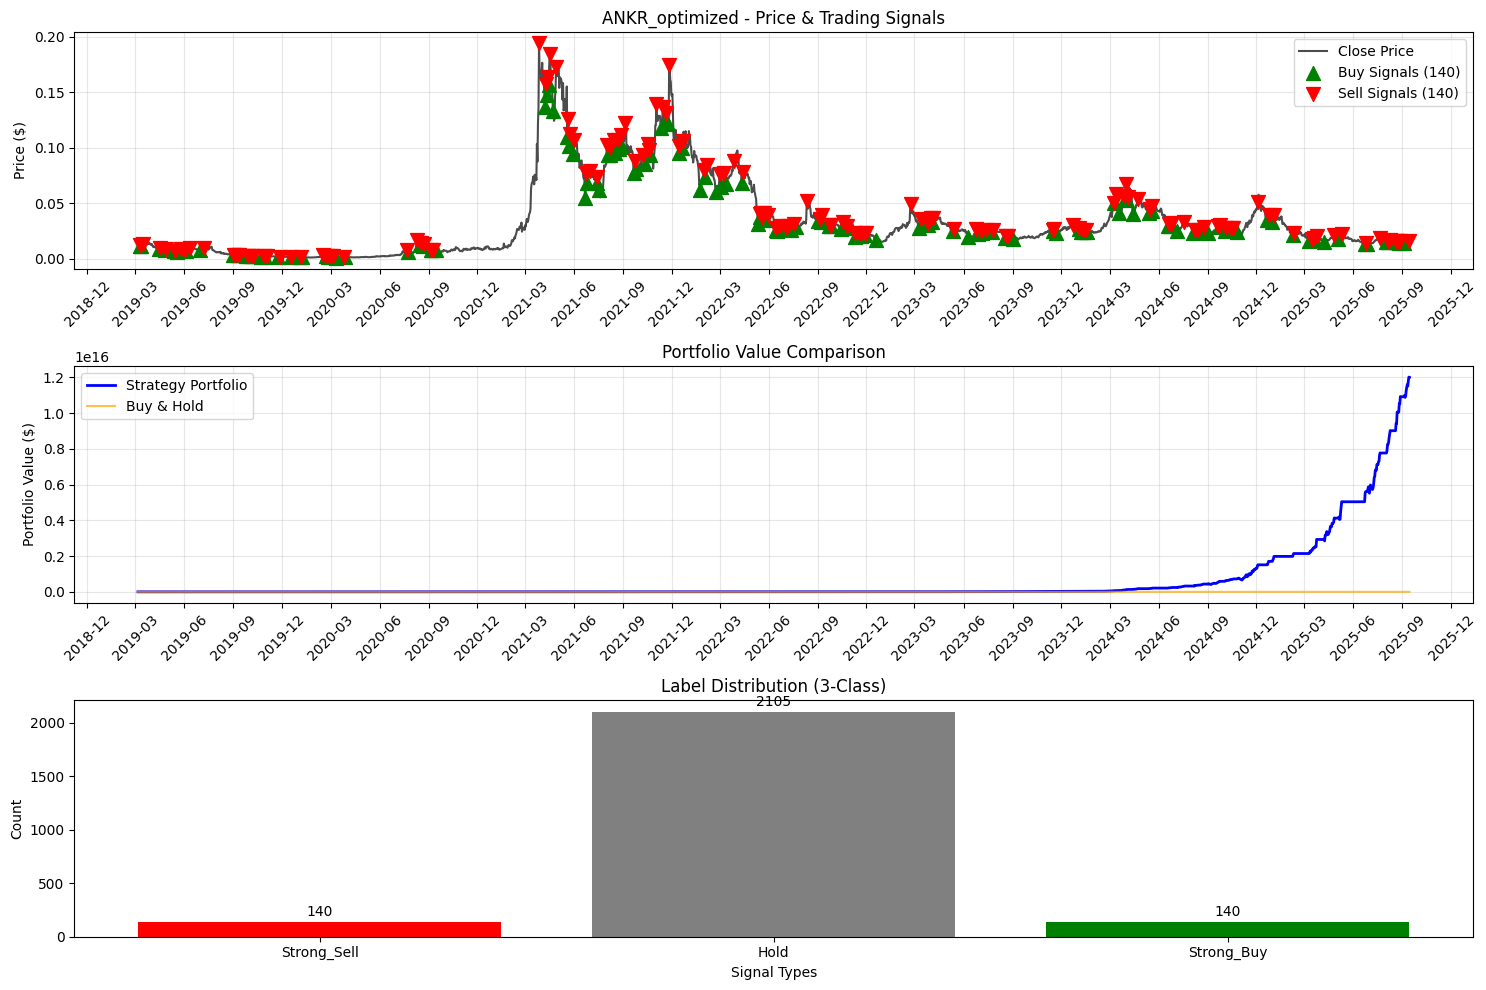


API3_optimized 백테스팅 결과:
전략 수익률: 186435512546186.72%
Buy & Hold 수익률: -27.49%
초과 수익률: 186435512546214.22%
샤프 비율: 4.59
최대 손실폭: -24.29%
총 거래 횟수: 300회
승률: 100.00%
평균 거래수익률: 22.75%
최종 자산: $18,643,551,254,628,672


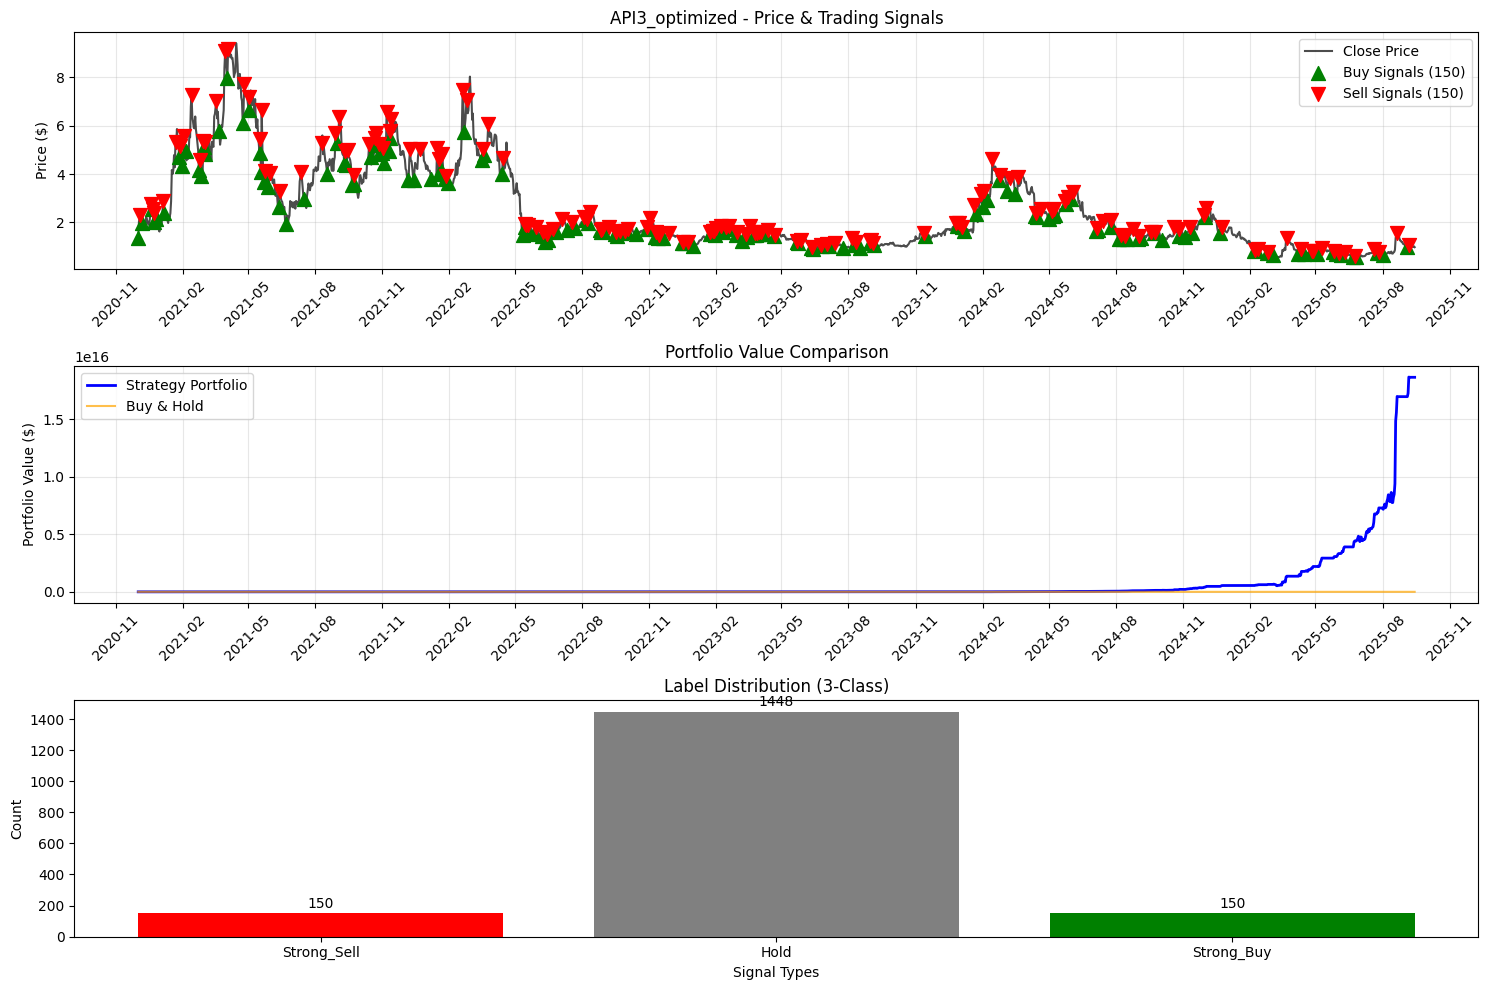


APT21794_optimized 백테스팅 결과:
전략 수익률: 16606646.55%
Buy & Hold 수익률: -37.45%
초과 수익률: 16606684.00%
샤프 비율: 4.74
최대 손실폭: -21.56%
총 거래 횟수: 190회
승률: 100.00%
평균 거래수익률: 16.14%
최종 자산: $1,660,674,655


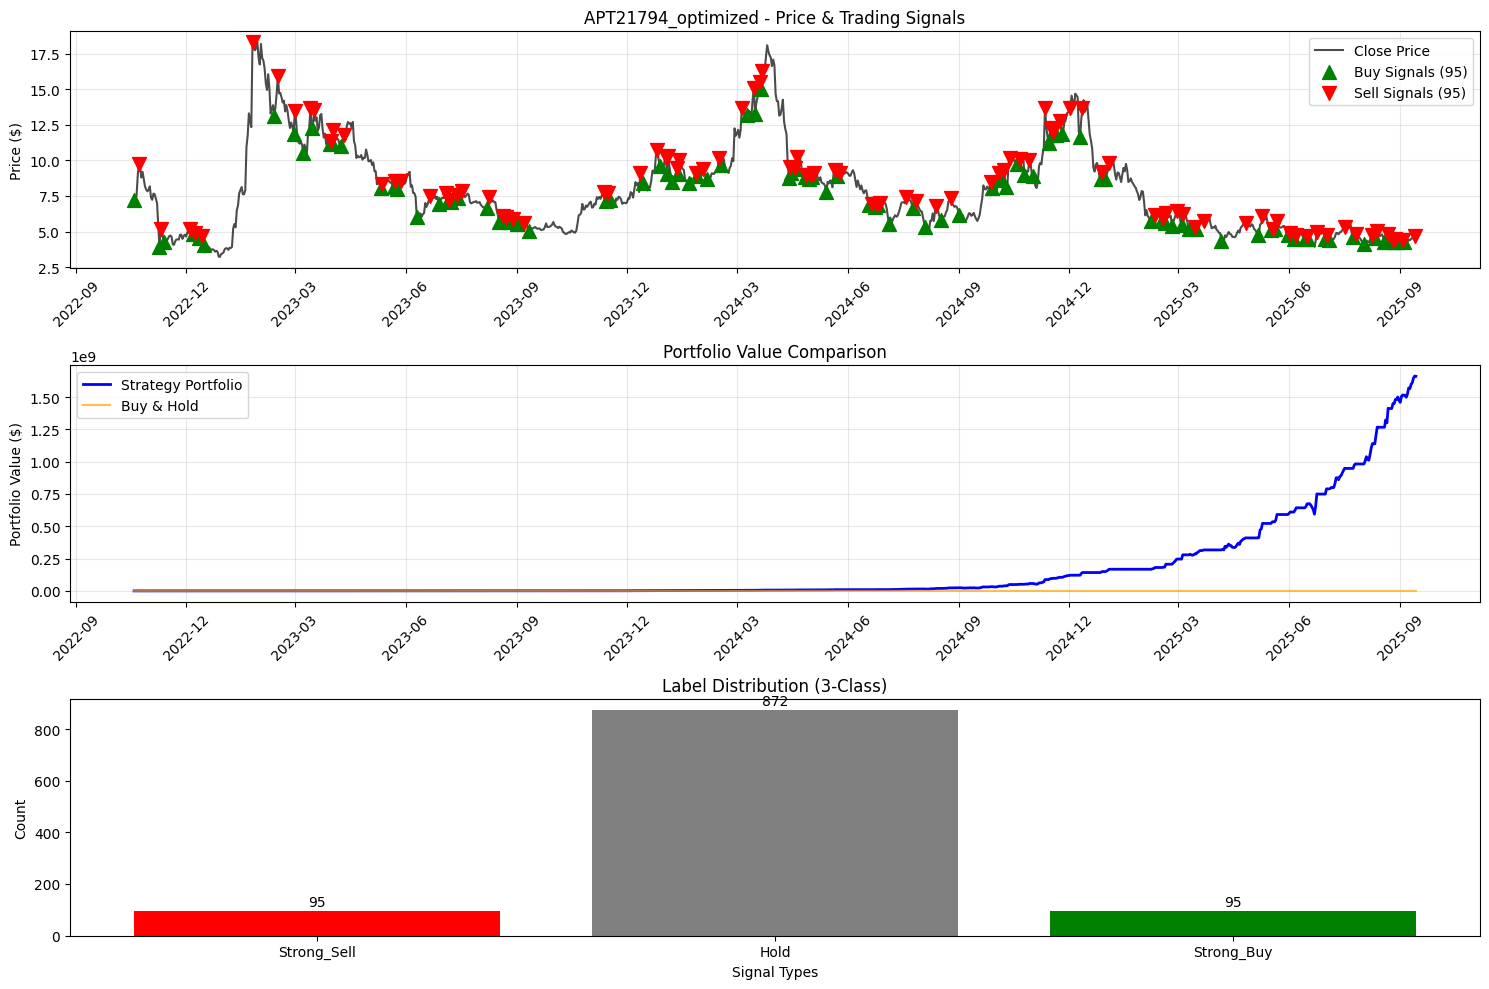


ARB11841_optimized 백테스팅 결과:
전략 수익률: 970495.50%
Buy & Hold 수익률: -61.38%
초과 수익률: 970556.89%
샤프 비율: 4.76
최대 손실폭: -15.18%
총 거래 횟수: 126회
승률: 100.00%
평균 거래수익률: 17.22%
최종 자산: $97,059,550


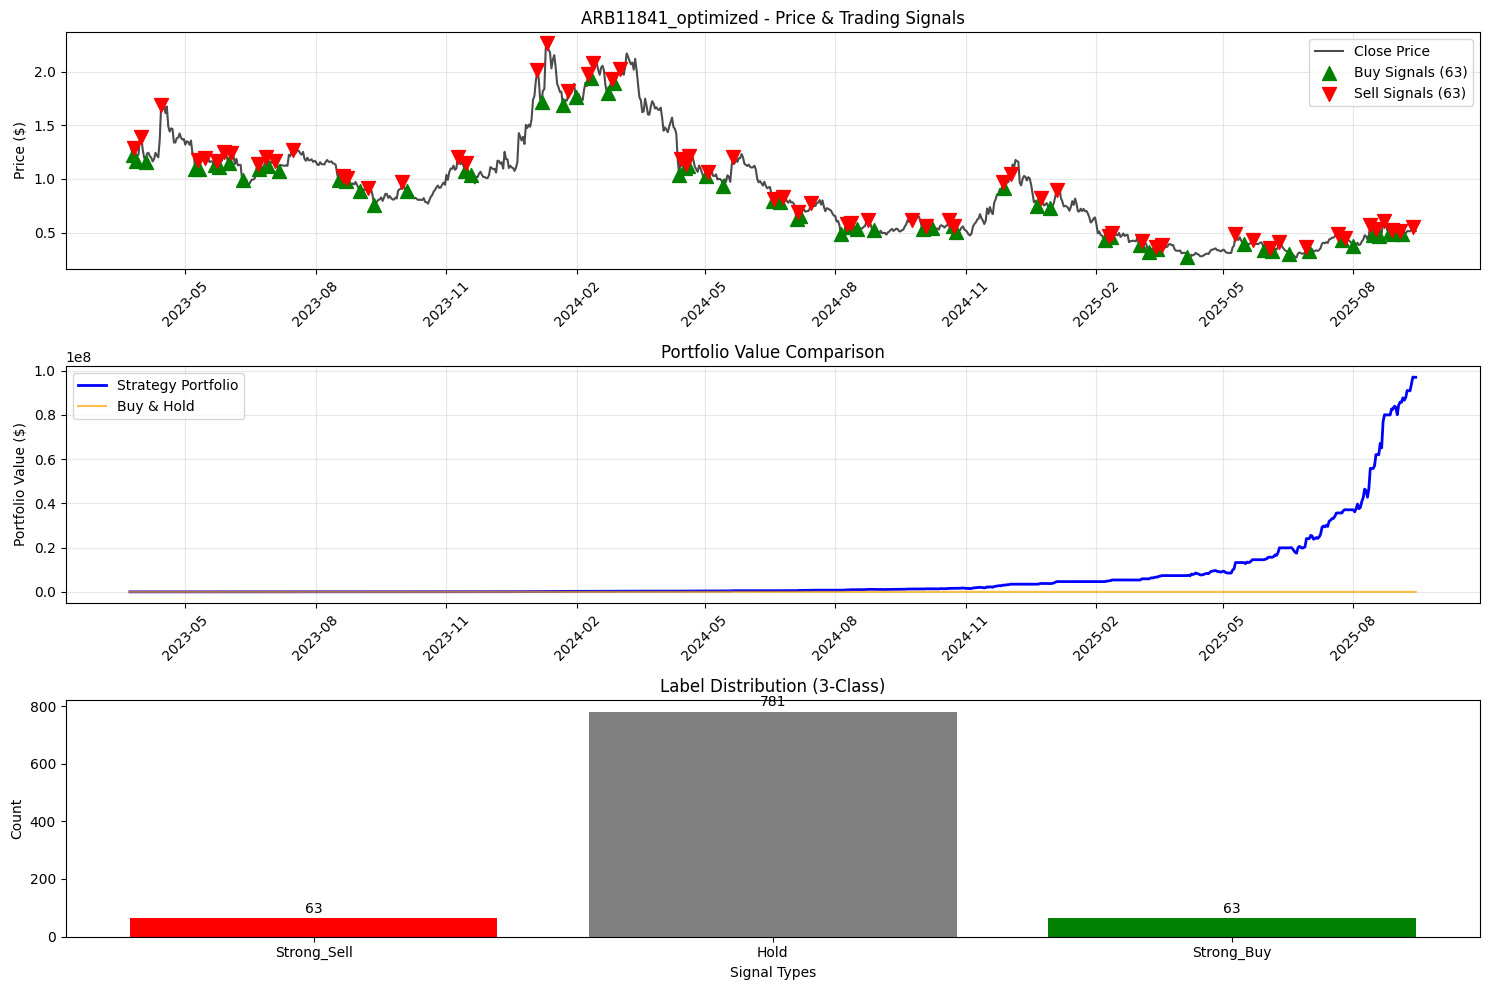


ASTR_optimized 백테스팅 결과:
전략 수익률: 58410980.47%
Buy & Hold 수익률: -86.46%
초과 수익률: 58411066.93%
샤프 비율: 4.67
최대 손실폭: -23.83%
총 거래 횟수: 176회
승률: 100.00%
평균 거래수익률: 18.71%
최종 자산: $5,841,108,047


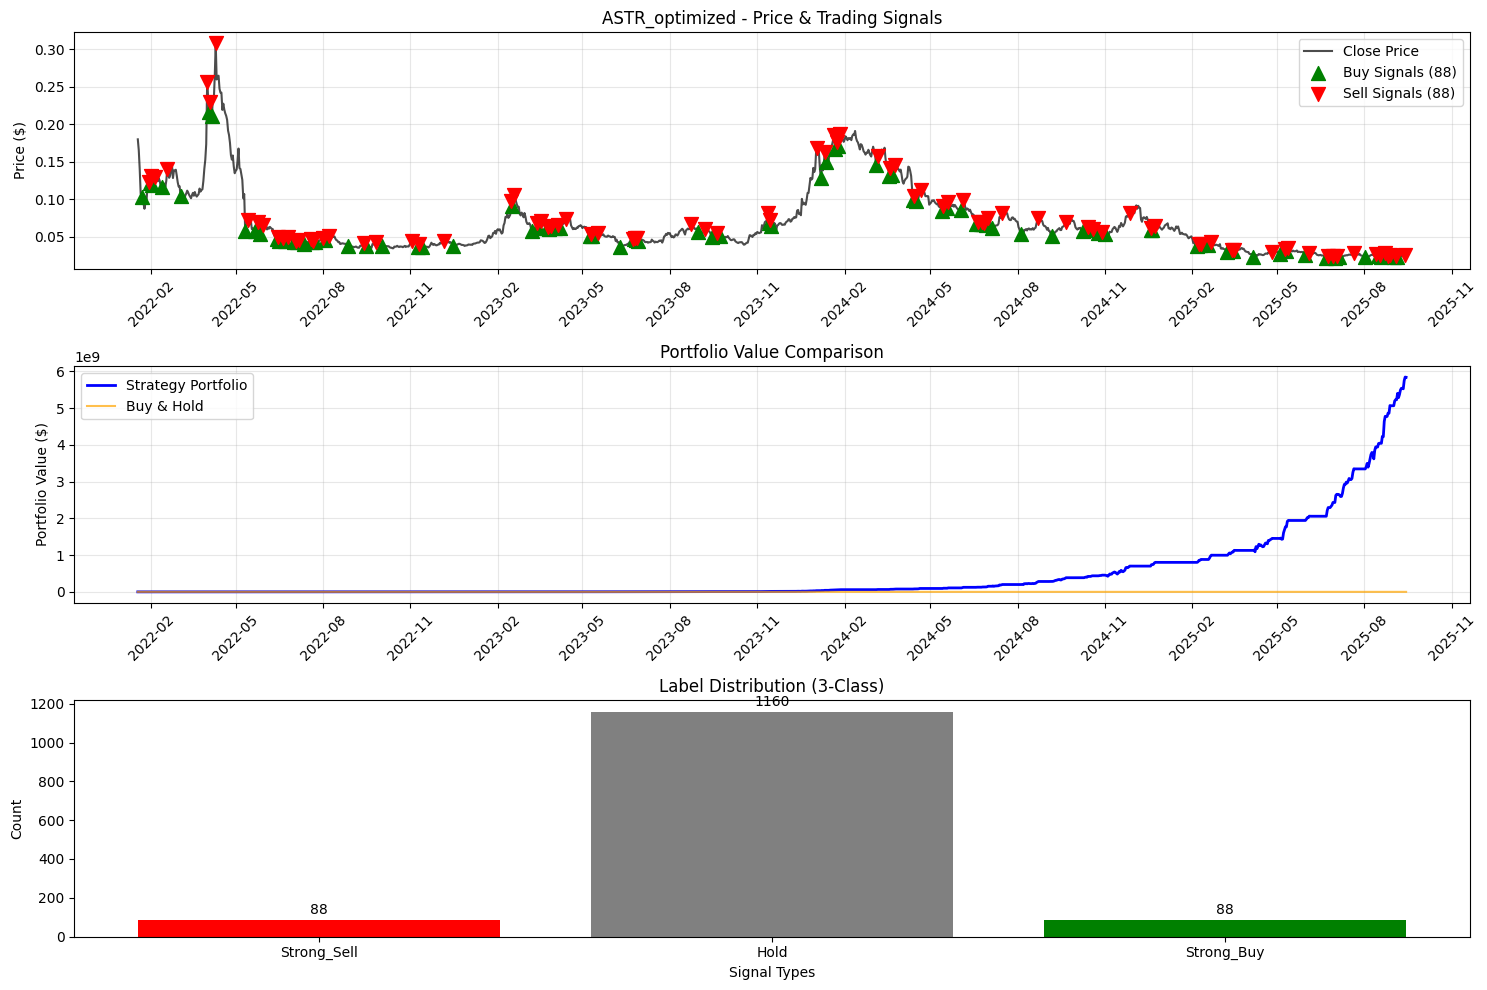


ATOM_optimized 백테스팅 결과:
전략 수익률: 574914042998790.12%
Buy & Hold 수익률: -28.87%
초과 수익률: 574914042998819.00%
샤프 비율: 4.96
최대 손실폭: -26.43%
총 거래 횟수: 362회
승률: 100.00%
평균 거래수익률: 20.20%
최종 자산: $57,491,404,299,889,016


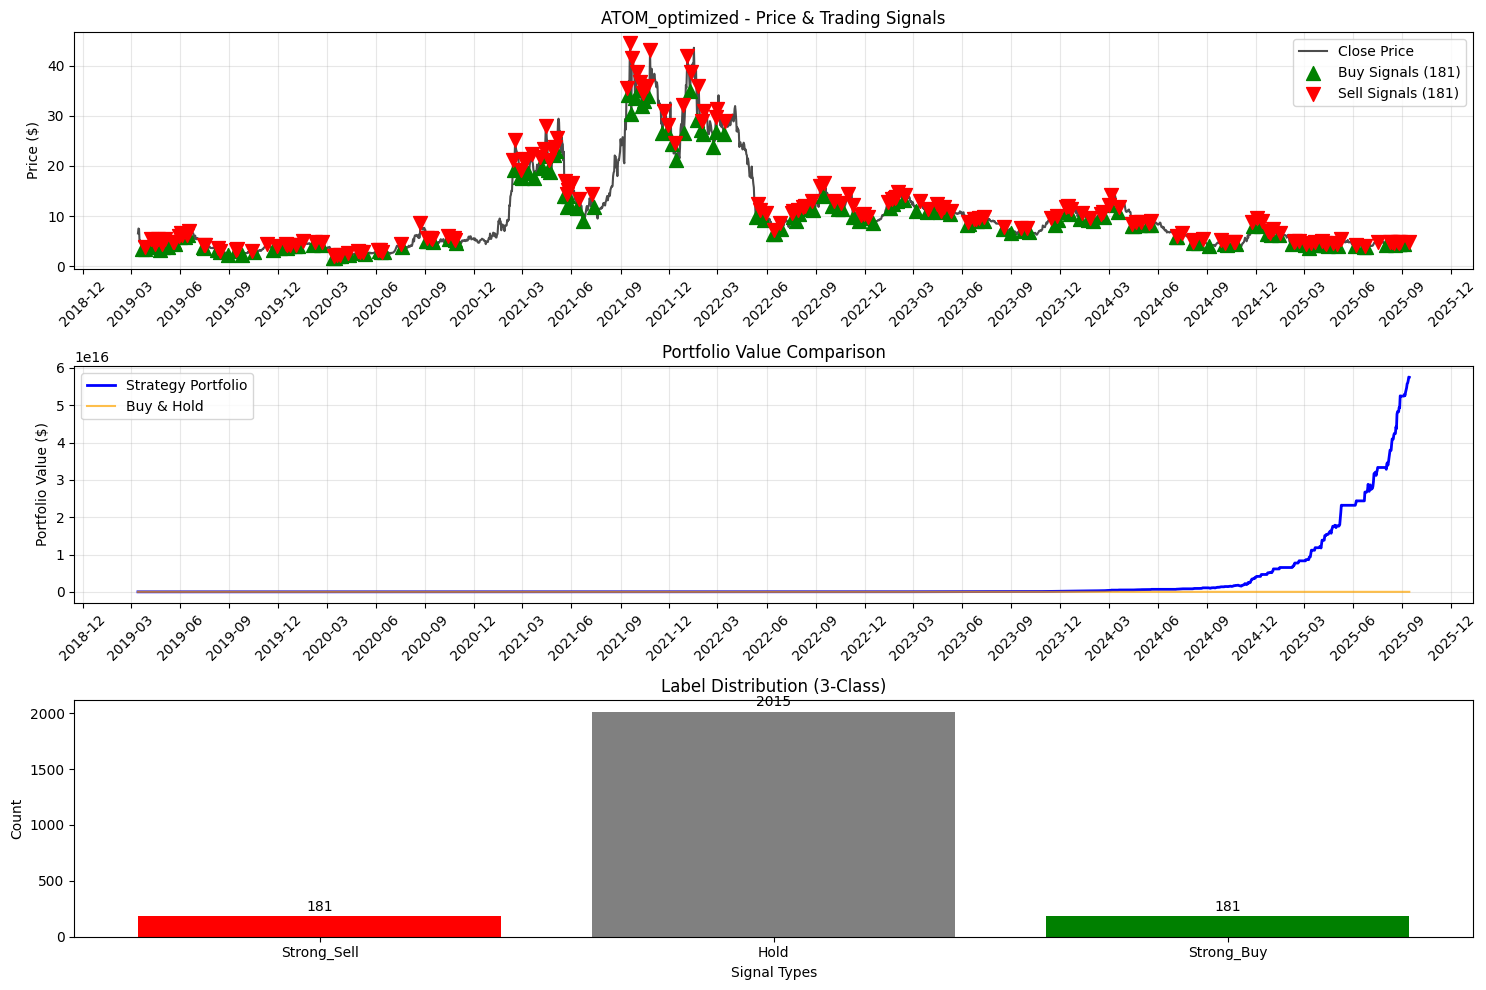


전체 백테스팅 결과 요약:
            Symbol        Total_Return       Excess_Return  Sharpe_Ratio  Win_Rate  Num_Trades
   1INCH_optimized       766337150.683       766337151.569         4.906     0.993         270
    AAVE_optimized   1044010764290.008   1044010763697.562         0.464     1.000         260
     ADA_optimized 229813482928912.875 229813482928886.125         3.678     0.994         336
    ALGO_optimized    328355247915.020    328355247915.945         4.707     1.000         308
    ANKR_optimized   1199971930531.031   1199971930530.885         4.137     1.000         280
    API3_optimized   1864355125461.867   1864355125462.142         4.591     1.000         300
APT21794_optimized          166066.466          166066.840         4.738     1.000         190
ARB11841_optimized            9704.955            9705.569         4.761     1.000         126
    ASTR_optimized          584109.805          584110.669         4.673     1.000         176
    ATOM_optimized   5749140429987

In [6]:

save_path_1 = "/workspace/AI모델/projects/coin/data/labeling/01" 

# 실행 코드
if __name__ == "__main__":
    # 개별 종목 백테스팅 실행 (기간 설정 포함)
    backtester = run_individual_backtest(
        data_path=save_path_1,
        start_date='2015-01-01',    # 백테스팅 시작 날짜
        end_date='2025-12-31',      # 백테스팅 종료 날짜
        max_stocks=10,               # 처음 3개 종목만 테스트
        initial_capital=10000       # 초기 투자 금액
    )
    
    # 특정 종목만 테스트하려면:
    # backtester = run_individual_backtest(
    #     data_path=data_path,
    #     start_date='2005-01-01',
    #     end_date='2010-12-31',
    #     symbols=['AAPL', 'MSFT'],  # 원하는 종목 코드
    #     initial_capital=50000
    # )

# 연도별 백테스팅 실행

연도별 백테스팅 시작

2003년 백테스팅 실행 중...
파일 패턴 발견: *_optimized.csv (142개)
CSV 파일 로딩 중... (142개)


  0%|          | 0/142 [00:00<?, ?it/s]

100%|██████████| 142/142 [00:13<00:00, 10.18it/s]


로딩 완료: 141개 종목

Backtesting Period: 2003-01-01 to 2003-12-31
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 10 stocks...

AAPL_optimized 백테스팅 결과:
전략 수익률: 532.77%
Buy & Hold 수익률: 44.39%
초과 수익률: 488.38%
샤프 비율: 7.72
최대 손실폭: -1.39%
총 거래 횟수: 60회
승률: 100.00%
평균 거래수익률: 6.77%
최종 자산: $63,277


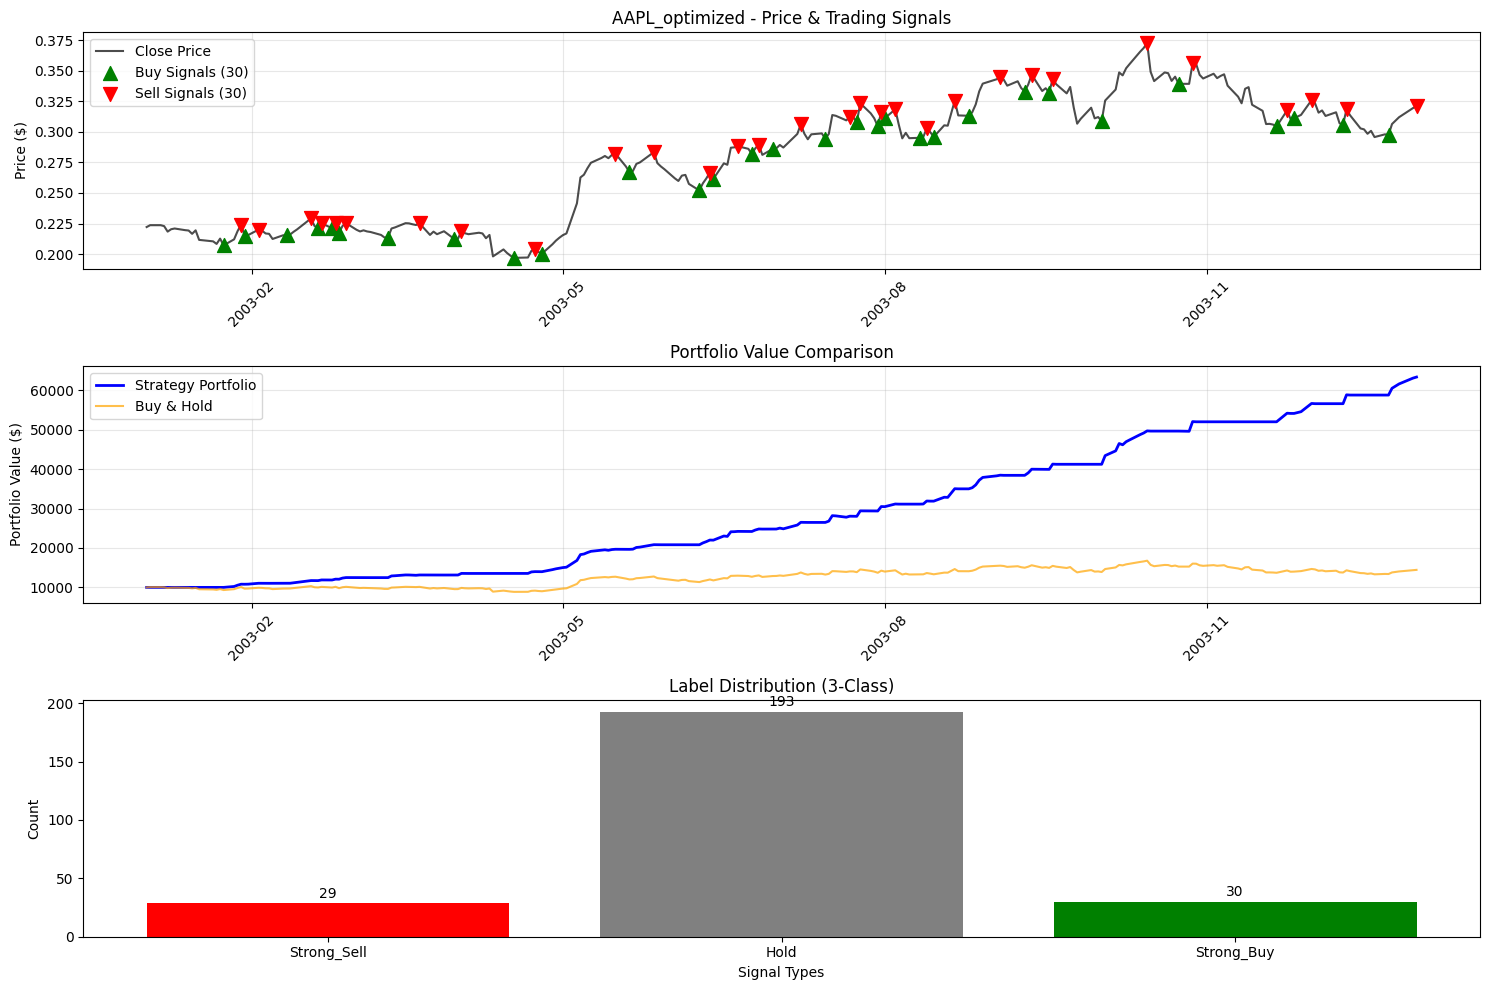


ABT_optimized 백테스팅 결과:
전략 수익률: 188.67%
Buy & Hold 수익률: 19.12%
초과 수익률: 169.55%
샤프 비율: 6.74
최대 손실폭: -2.40%
총 거래 횟수: 48회
승률: 100.00%
평균 거래수익률: 4.78%
최종 자산: $28,867


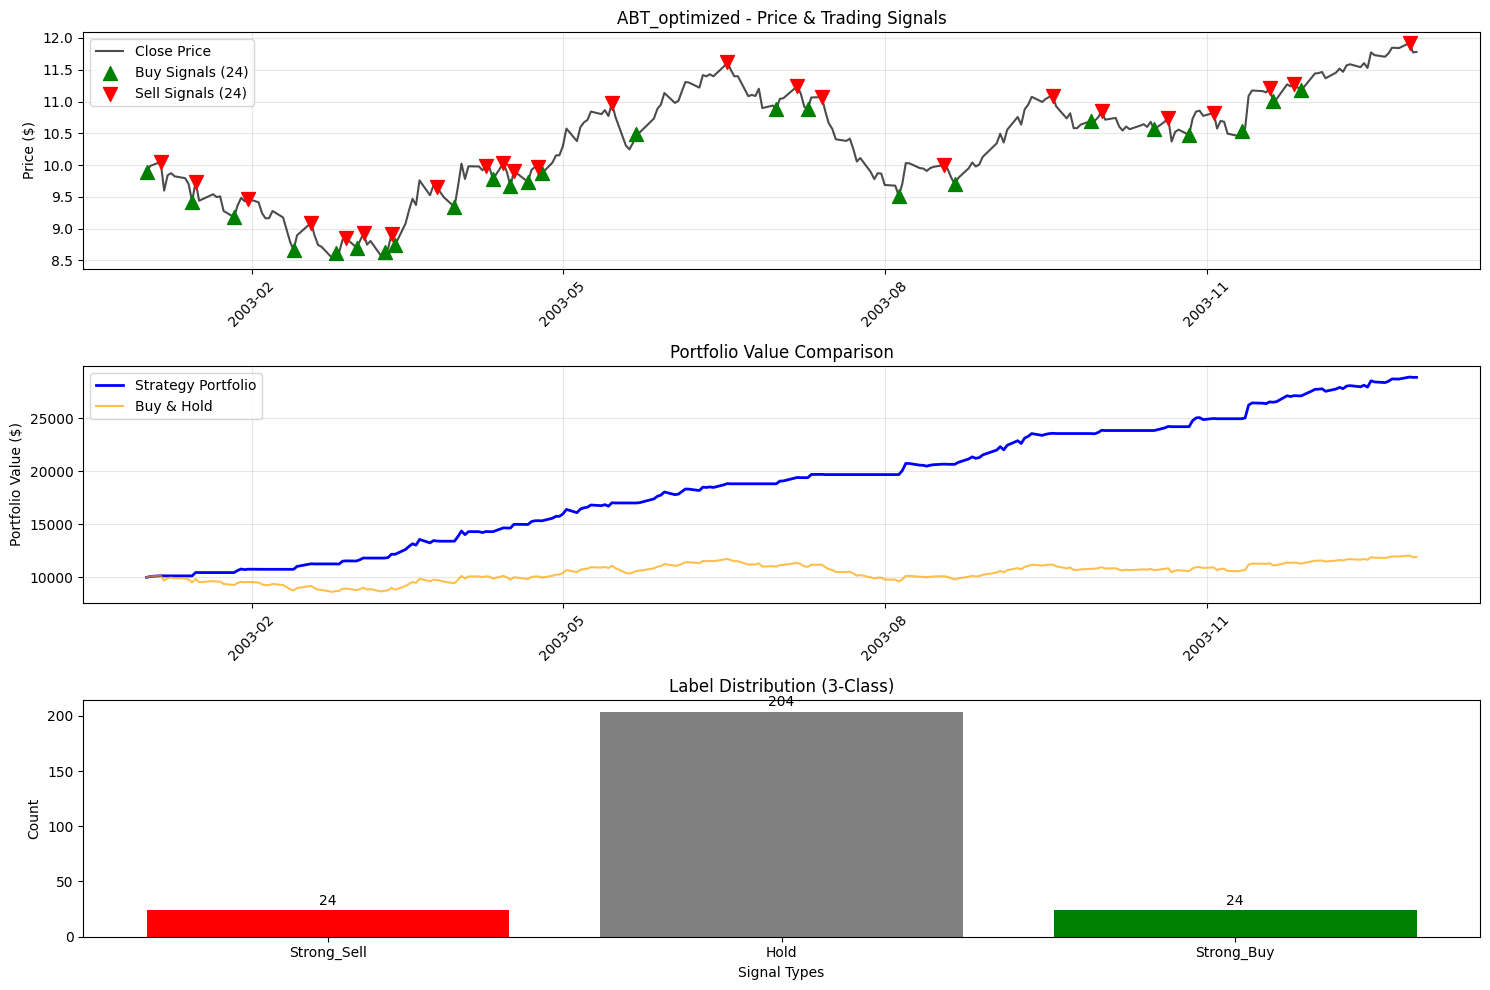


ACN_optimized 백테스팅 결과:
전략 수익률: 630.30%
Buy & Hold 수익률: 41.43%
초과 수익률: 588.87%
샤프 비율: 7.22
최대 손실폭: -3.50%
총 거래 횟수: 56회
승률: 100.00%
평균 거래수익률: 7.63%
최종 자산: $73,030


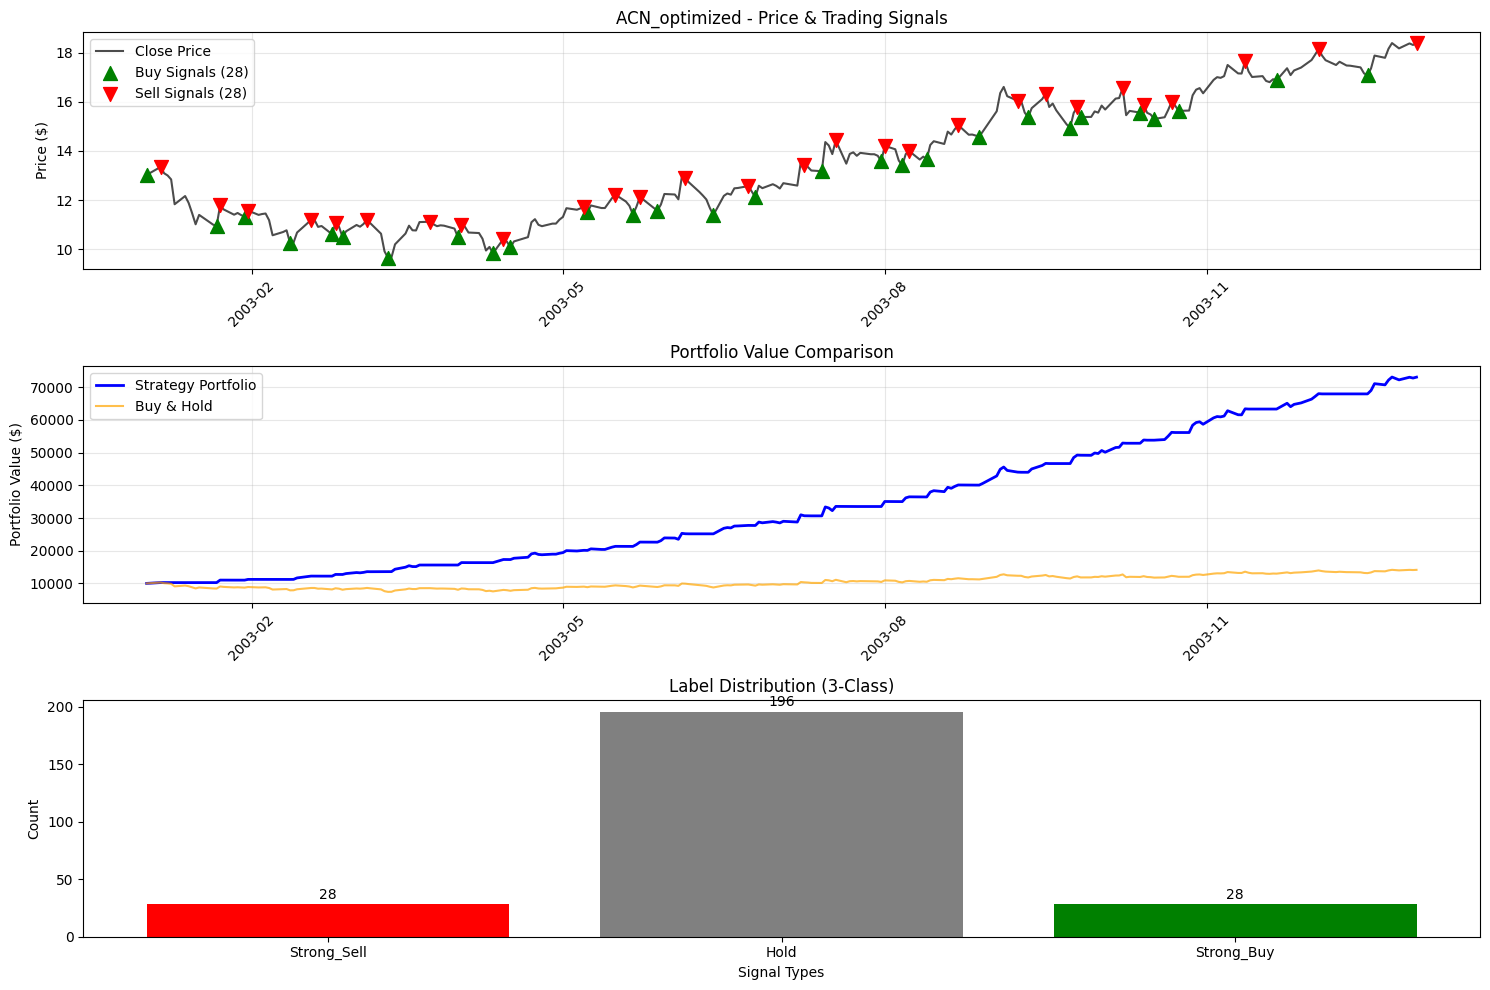


ADBE_optimized 백테스팅 결과:
전략 수익률: 663.22%
Buy & Hold 수익률: 52.90%
초과 수익률: 610.32%
샤프 비율: 7.92
최대 손실폭: -2.71%
총 거래 횟수: 58회
승률: 96.55%
평균 거래수익률: 7.64%
최종 자산: $76,322


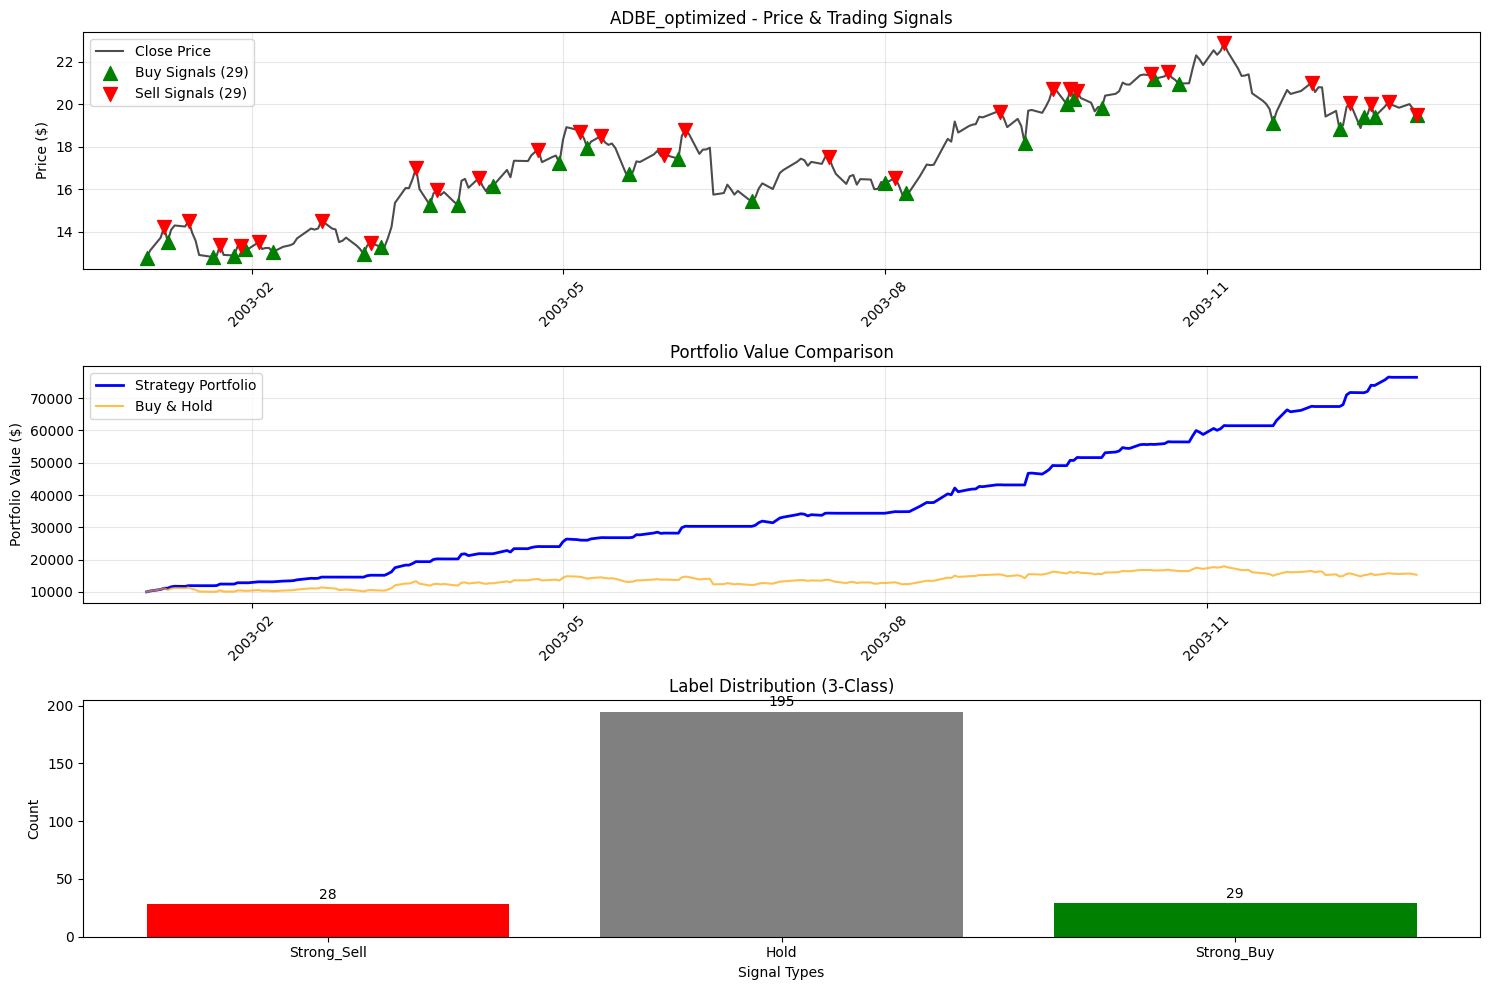


ADI_optimized 백테스팅 결과:
전략 수익률: 923.41%
Buy & Hold 수익률: 76.40%
초과 수익률: 847.01%
샤프 비율: 7.85
최대 손실폭: -3.04%
총 거래 횟수: 54회
승률: 100.00%
평균 거래수익률: 9.36%
최종 자산: $102,341


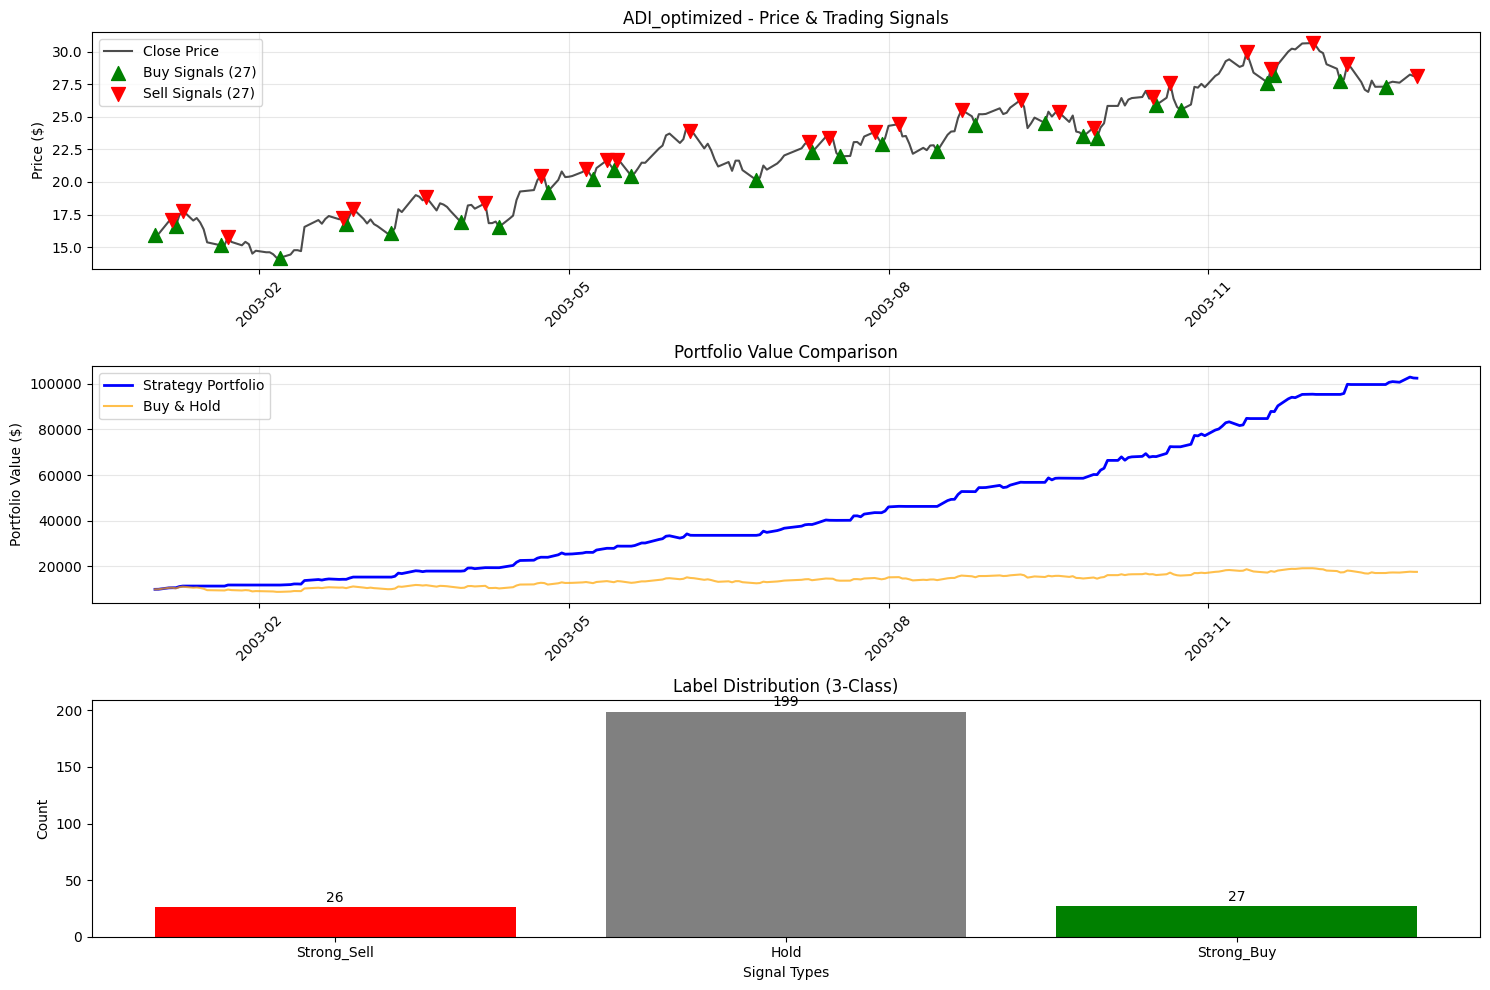


ADP_optimized 백테스팅 결과:
전략 수익률: 171.60%
Buy & Hold 수익률: -1.10%
초과 수익률: 172.70%
샤프 비율: 6.24
최대 손실폭: -4.88%
총 거래 횟수: 50회
승률: 100.00%
평균 거래수익률: 4.32%
최종 자산: $27,160


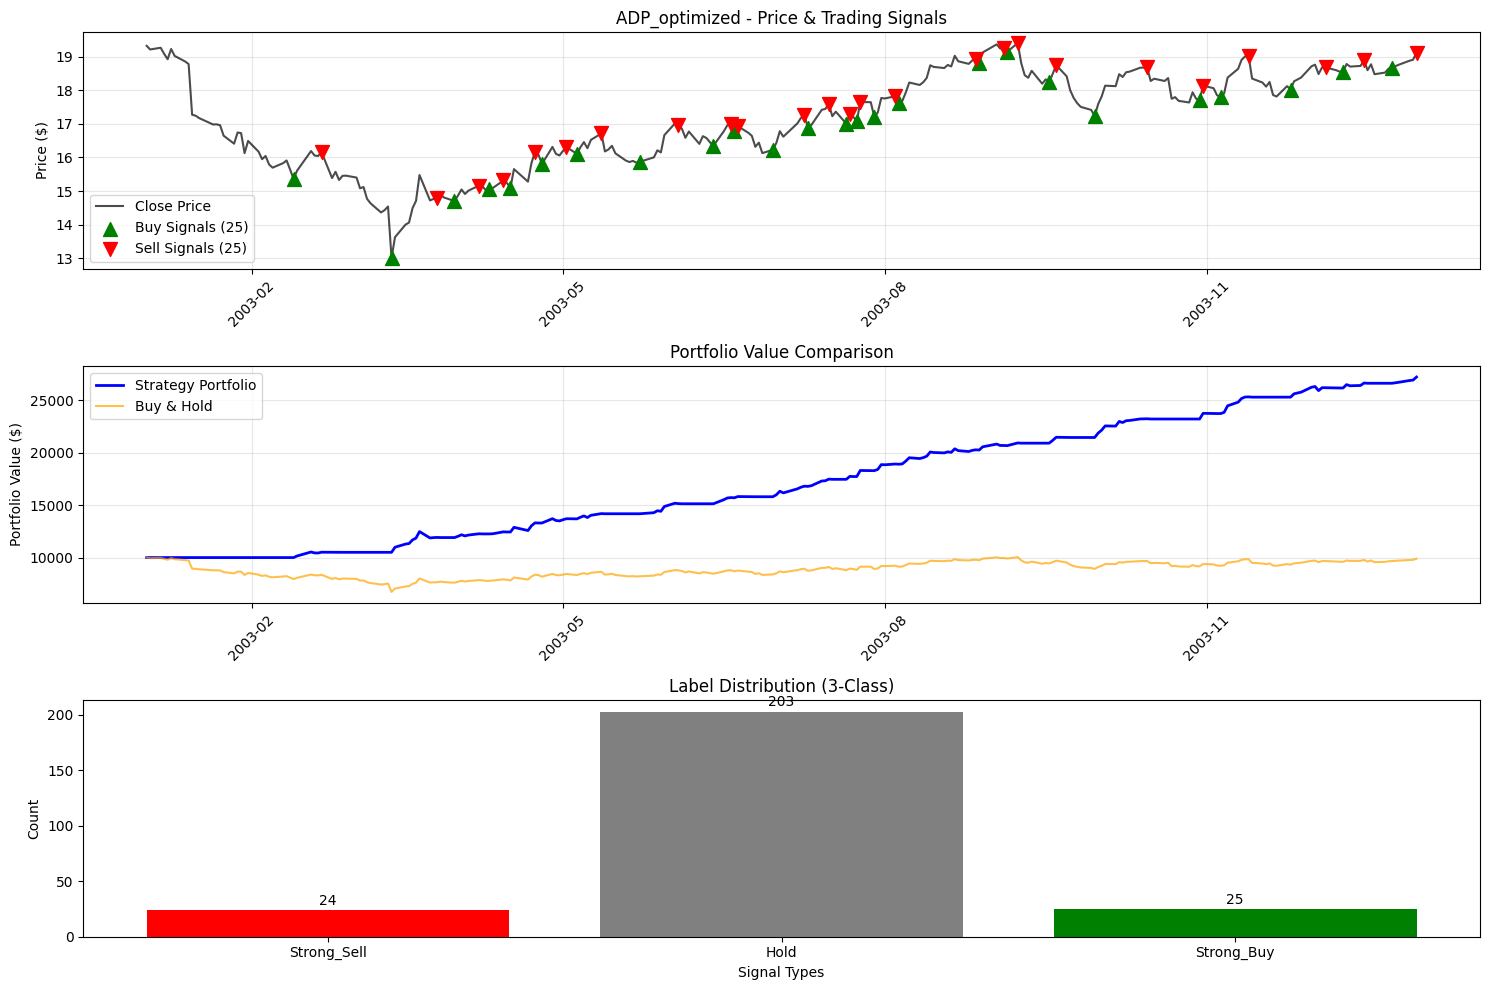


ADSK_optimized 백테스팅 결과:
전략 수익률: 485.65%
Buy & Hold 수익률: 69.49%
초과 수익률: 416.16%
샤프 비율: 6.45
최대 손실폭: -3.32%
총 거래 횟수: 50회
승률: 100.00%
평균 거래수익률: 7.73%
최종 자산: $58,565


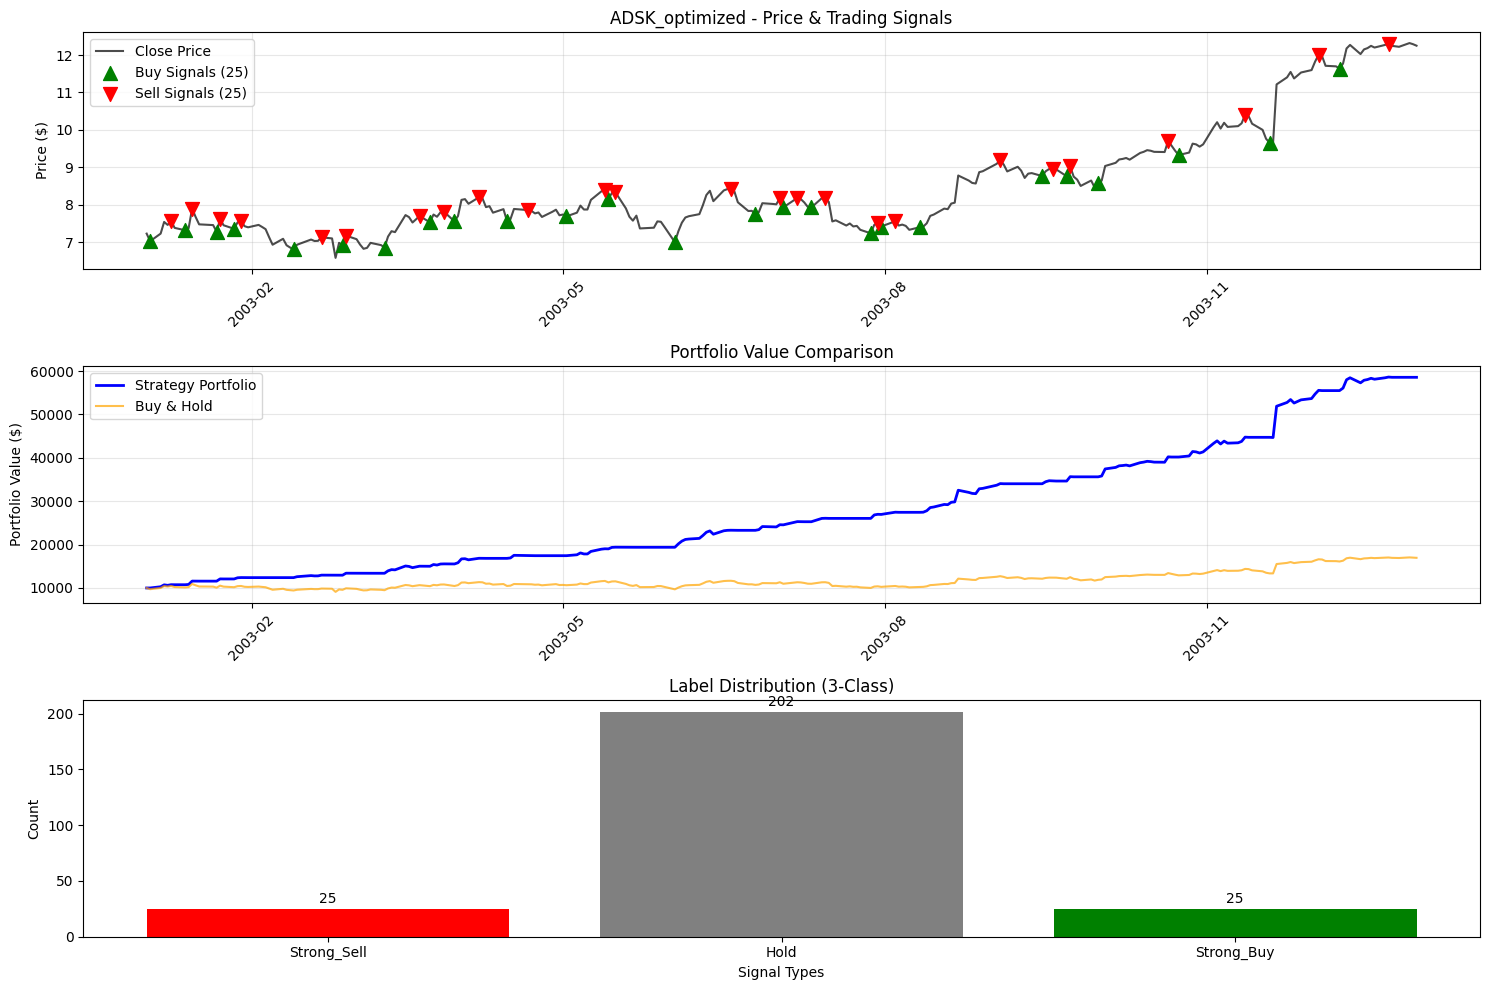


AEP_optimized 백테스팅 결과:
전략 수익률: 194.64%
Buy & Hold 수익률: 15.64%
초과 수익률: 178.99%
샤프 비율: 6.42
최대 손실폭: -4.14%
총 거래 횟수: 44회
승률: 100.00%
평균 거래수익률: 5.32%
최종 자산: $29,464


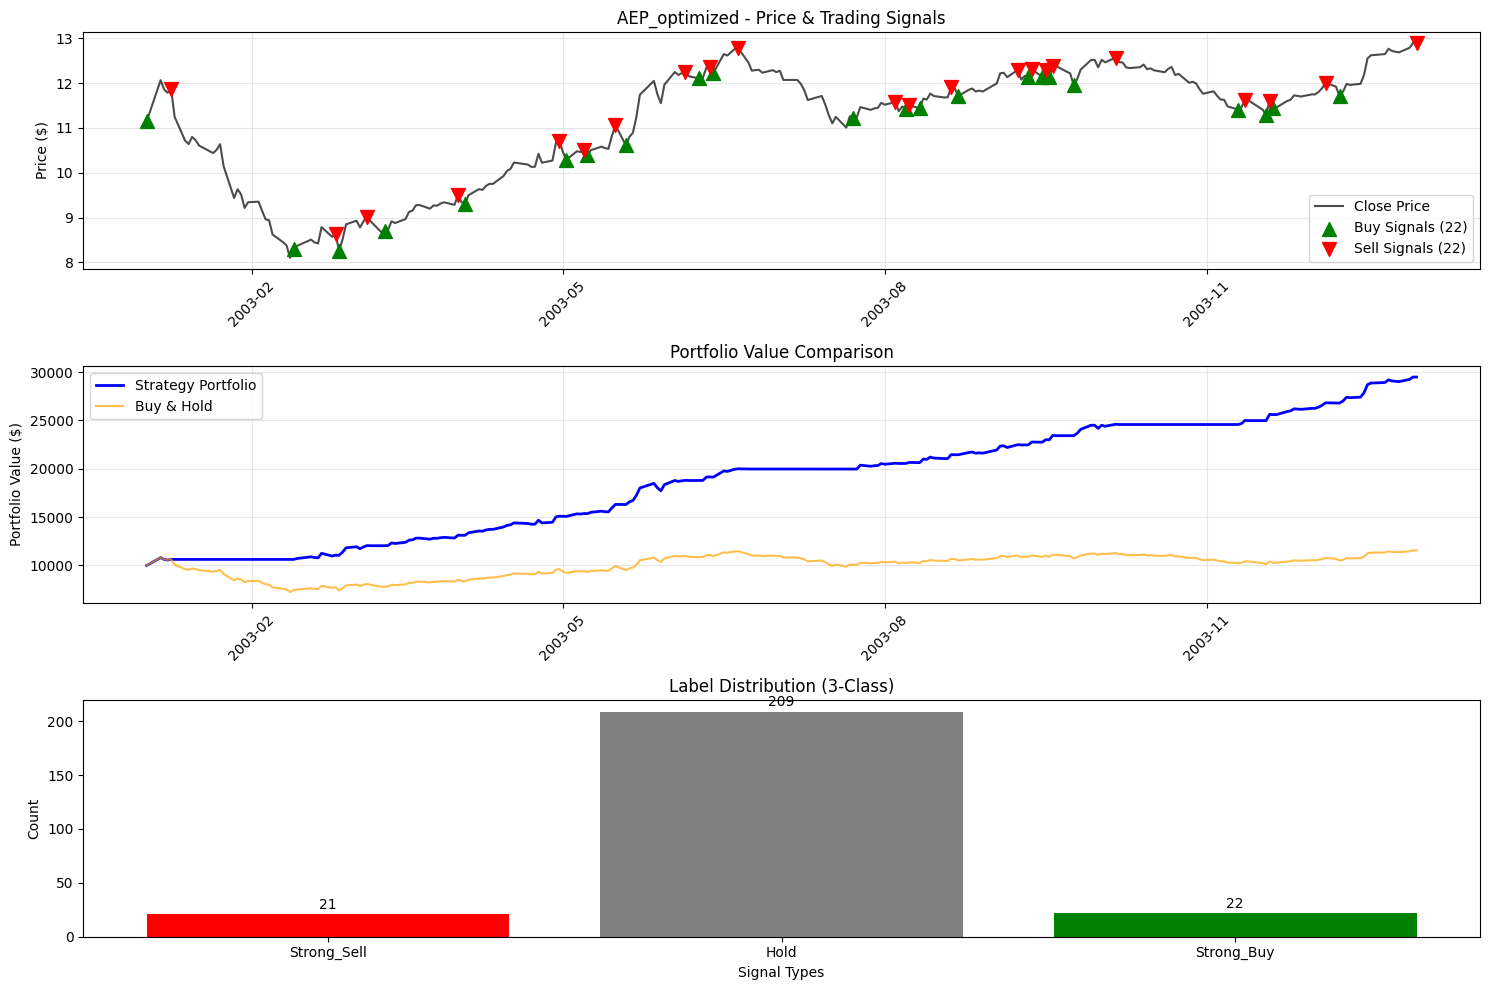


AIG_optimized 백테스팅 결과:
전략 수익률: 266.40%
Buy & Hold 수익률: 10.36%
초과 수익률: 256.04%
샤프 비율: 6.62
최대 손실폭: -4.70%
총 거래 횟수: 48회
승률: 100.00%
평균 거래수익률: 5.86%
최종 자산: $36,640


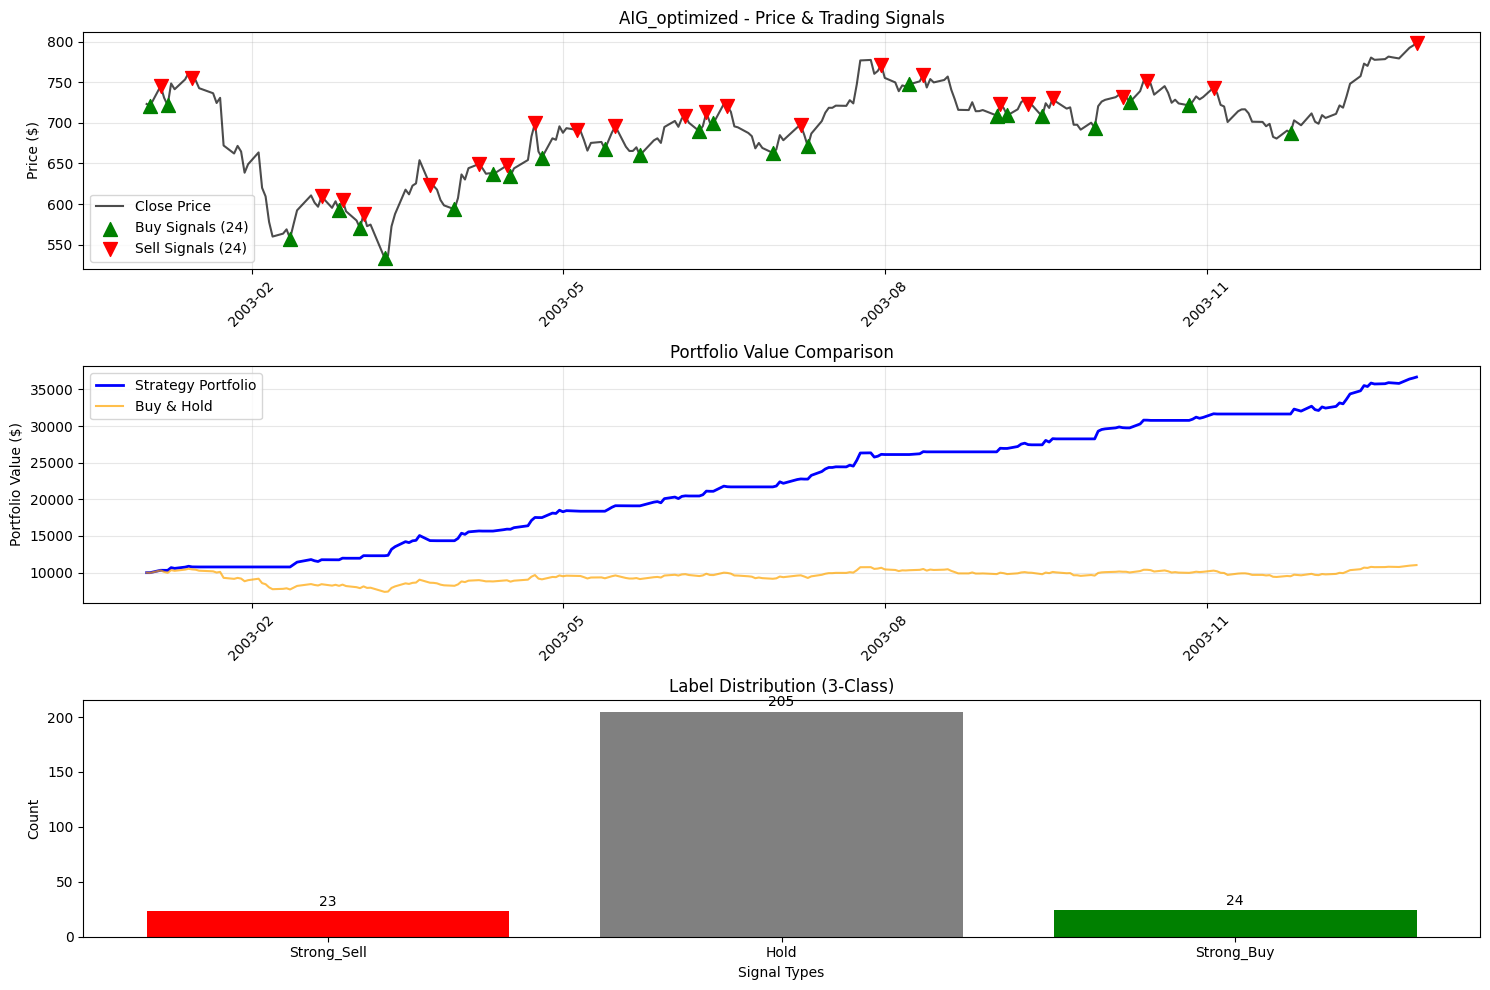


AMAT_optimized 백테스팅 결과:
전략 수익률: 1028.55%
Buy & Hold 수익률: 60.51%
초과 수익률: 968.03%
샤프 비율: 8.16
최대 손실폭: -2.59%
총 거래 횟수: 54회
승률: 100.00%
평균 거래수익률: 9.84%
최종 자산: $112,855


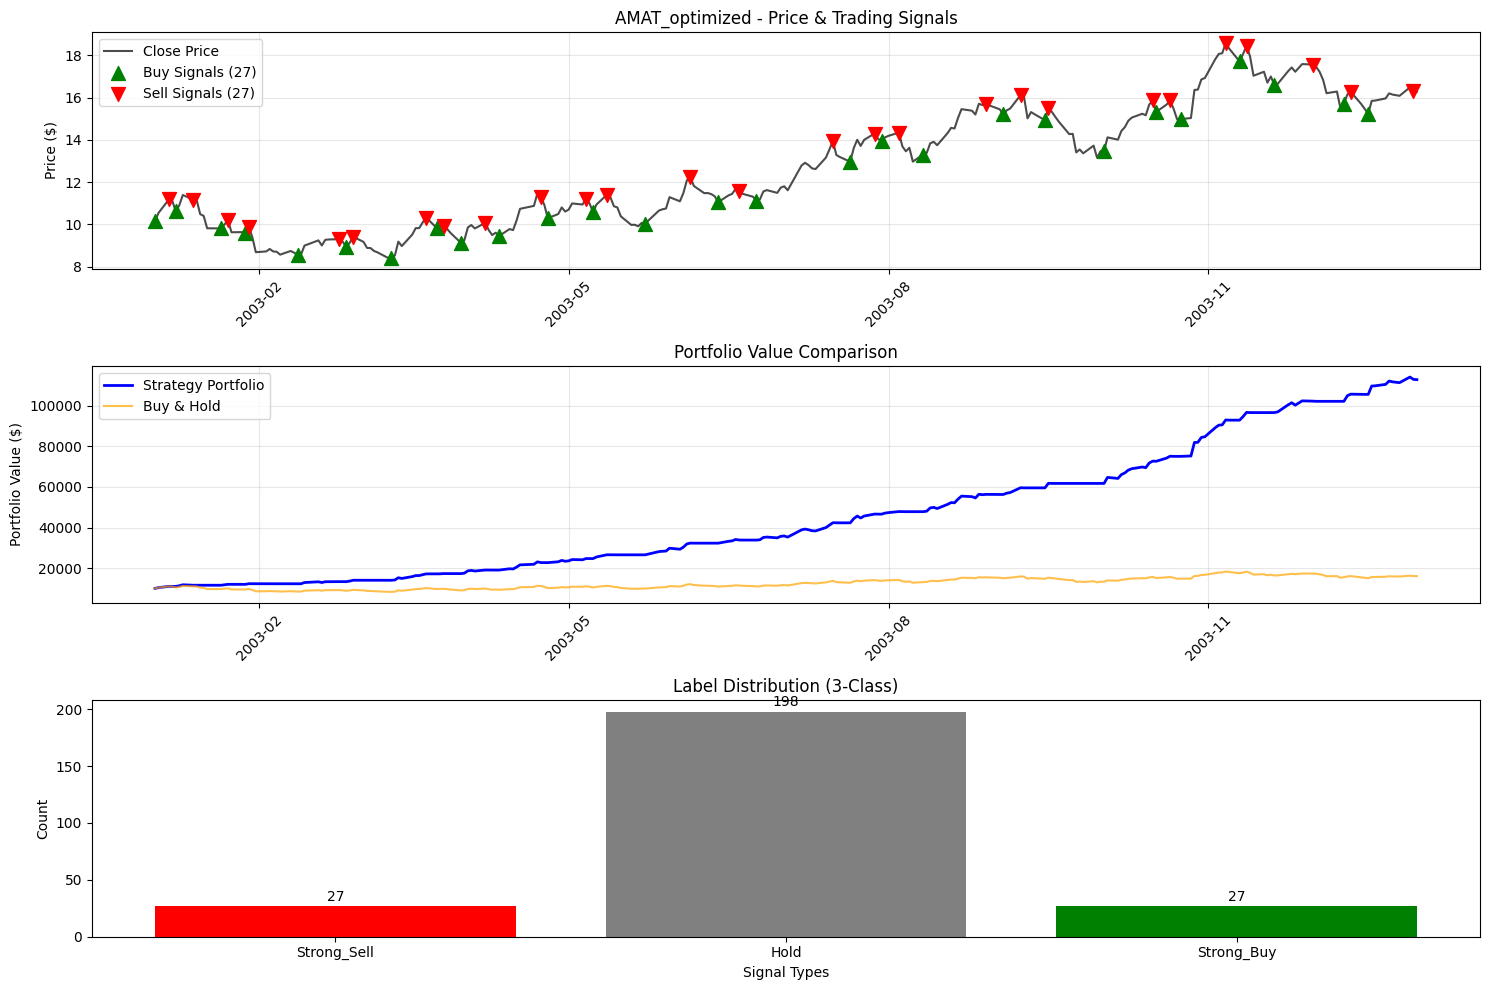


전체 백테스팅 결과 요약:
        Symbol  Total_Return  Excess_Return  Sharpe_Ratio  Win_Rate  Num_Trades
AAPL_optimized         5.328          4.884         7.724     1.000          60
 ABT_optimized         1.887          1.695         6.737     1.000          48
 ACN_optimized         6.303          5.889         7.225     1.000          56
ADBE_optimized         6.632          6.103         7.919     0.966          58
 ADI_optimized         9.234          8.470         7.851     1.000          54
 ADP_optimized         1.716          1.727         6.236     1.000          50
ADSK_optimized         4.857          4.162         6.450     1.000          50
 AEP_optimized         1.946          1.790         6.422     1.000          44
 AIG_optimized         2.664          2.560         6.620     1.000          48
AMAT_optimized        10.285          9.680         8.158     1.000          54

평균 통계:
평균 수익률: 508.52%
평균 초과수익률: 469.60%
평균 샤프비율: 7.13
평균 승률: 99.66%
2003년 백테스팅 완료

2004년 백테스팅 실행 중...


100%|██████████| 142/142 [00:13<00:00, 10.74it/s]


로딩 완료: 141개 종목

Backtesting Period: 2004-01-01 to 2004-12-31
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 10 stocks...

AAPL_optimized 백테스팅 결과:
전략 수익률: 720.19%
Buy & Hold 수익률: 202.63%
초과 수익률: 517.56%
샤프 비율: 6.70
최대 손실폭: -2.92%
총 거래 횟수: 44회
승률: 100.00%
평균 거래수익률: 10.69%
최종 자산: $82,019


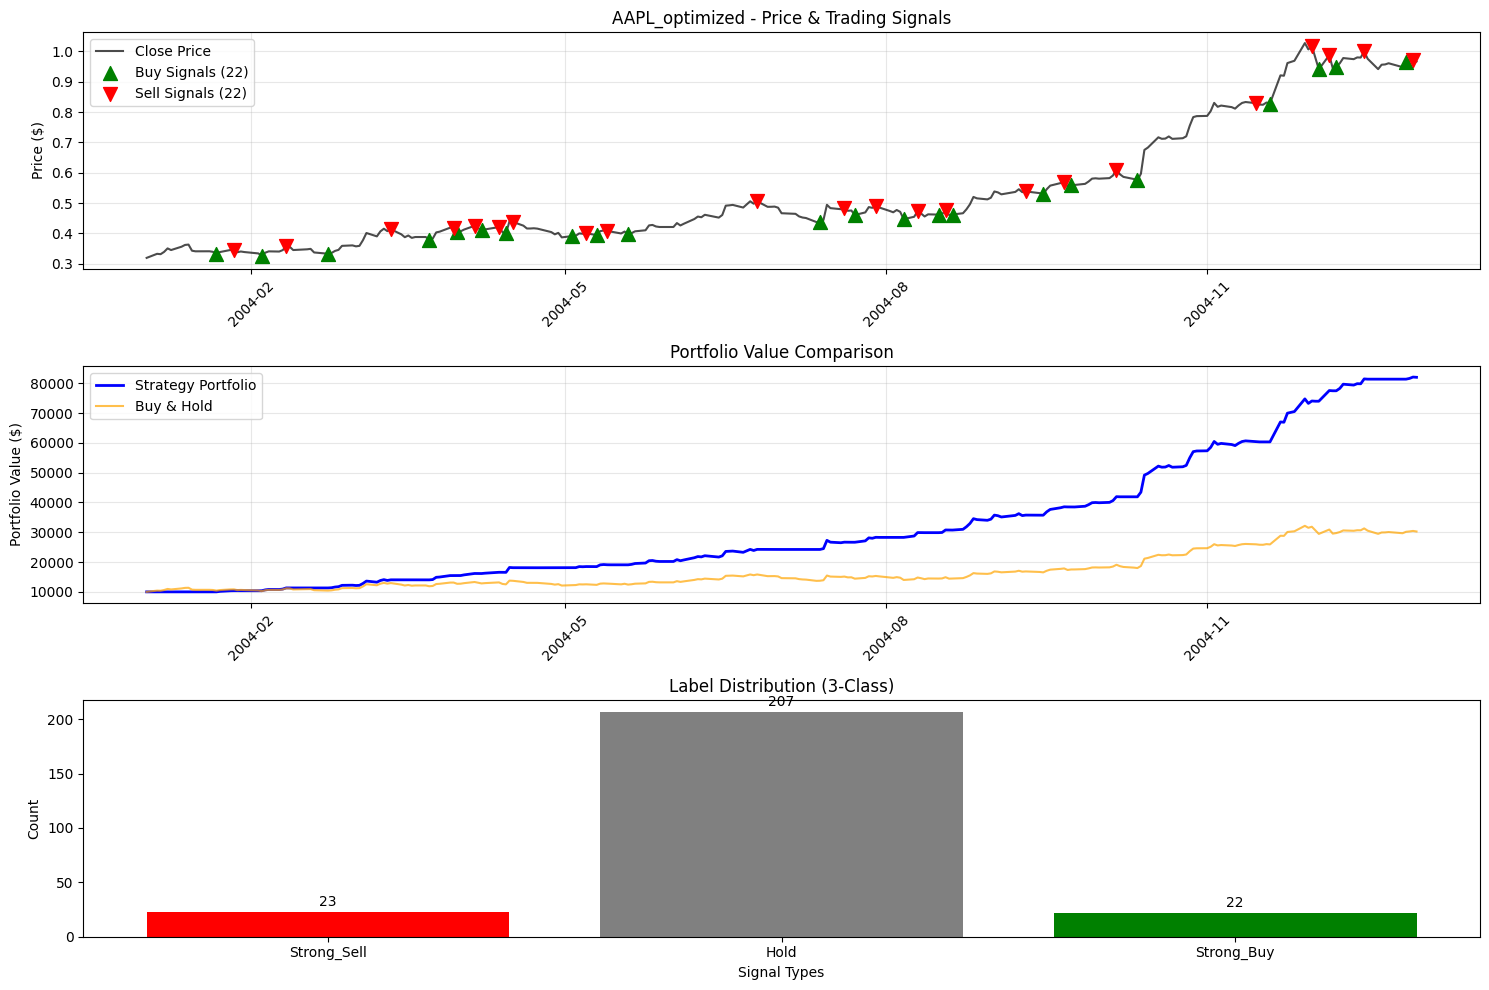


ABT_optimized 백테스팅 결과:
전략 수익률: 137.49%
Buy & Hold 수익률: 17.43%
초과 수익률: 120.07%
샤프 비율: 5.41
최대 손실폭: -1.89%
총 거래 횟수: 42회
승률: 100.00%
평균 거래수익률: 4.49%
최종 자산: $23,749


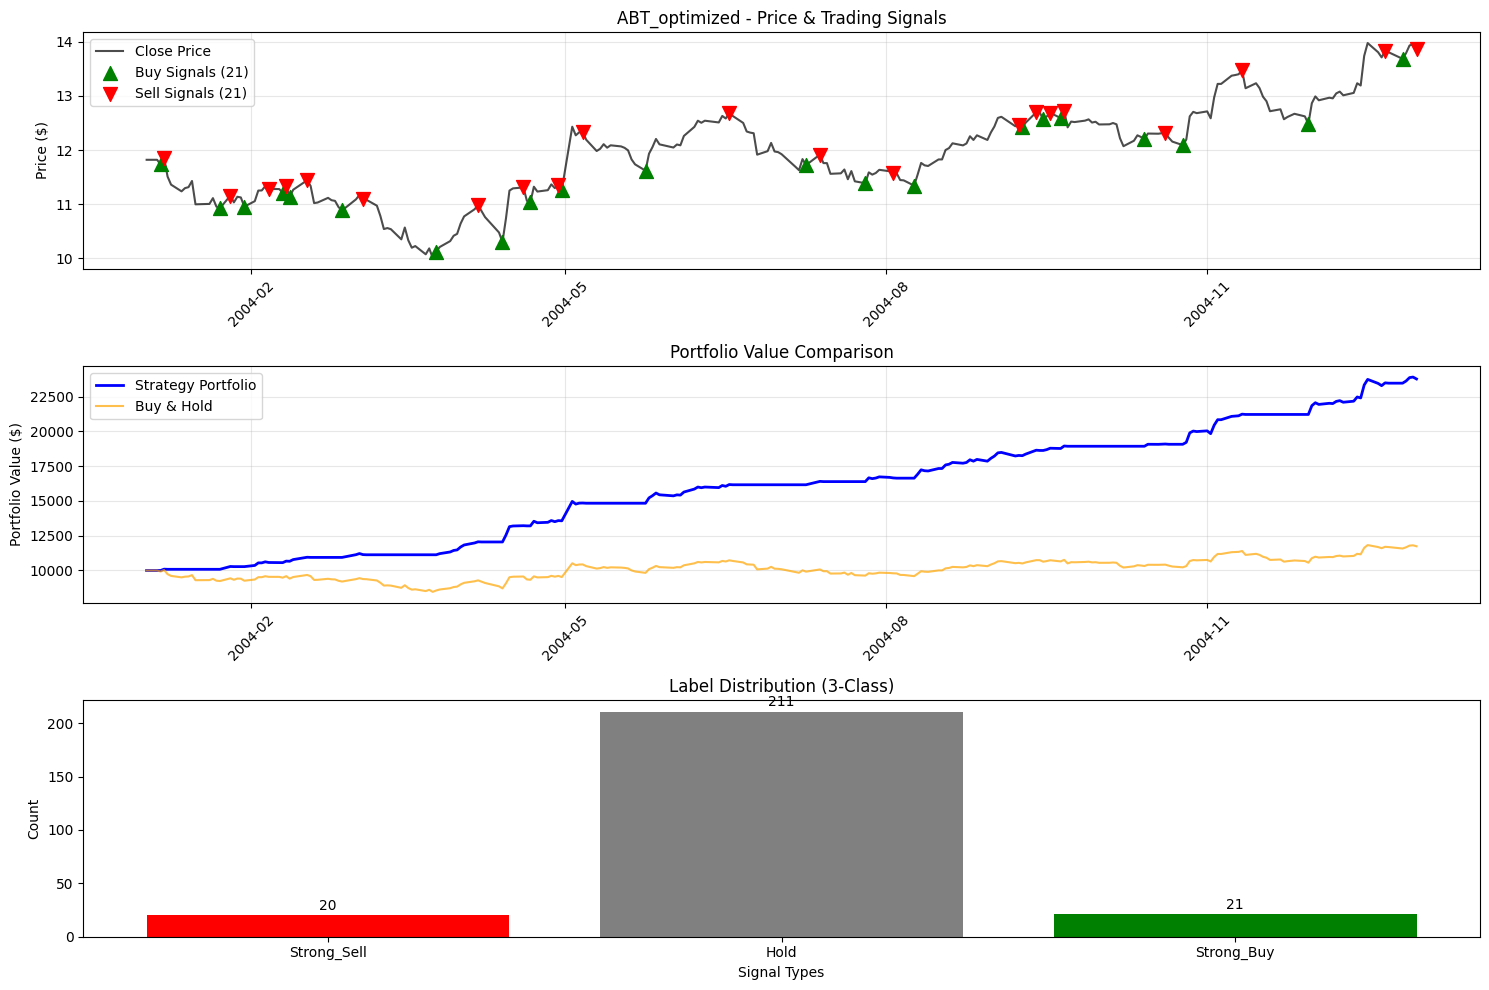


ACN_optimized 백테스팅 결과:
전략 수익률: 201.38%
Buy & Hold 수익률: 4.17%
초과 수익률: 197.21%
샤프 비율: 7.46
최대 손실폭: -2.18%
총 거래 횟수: 54회
승률: 100.00%
평균 거래수익률: 4.42%
최종 자산: $30,138


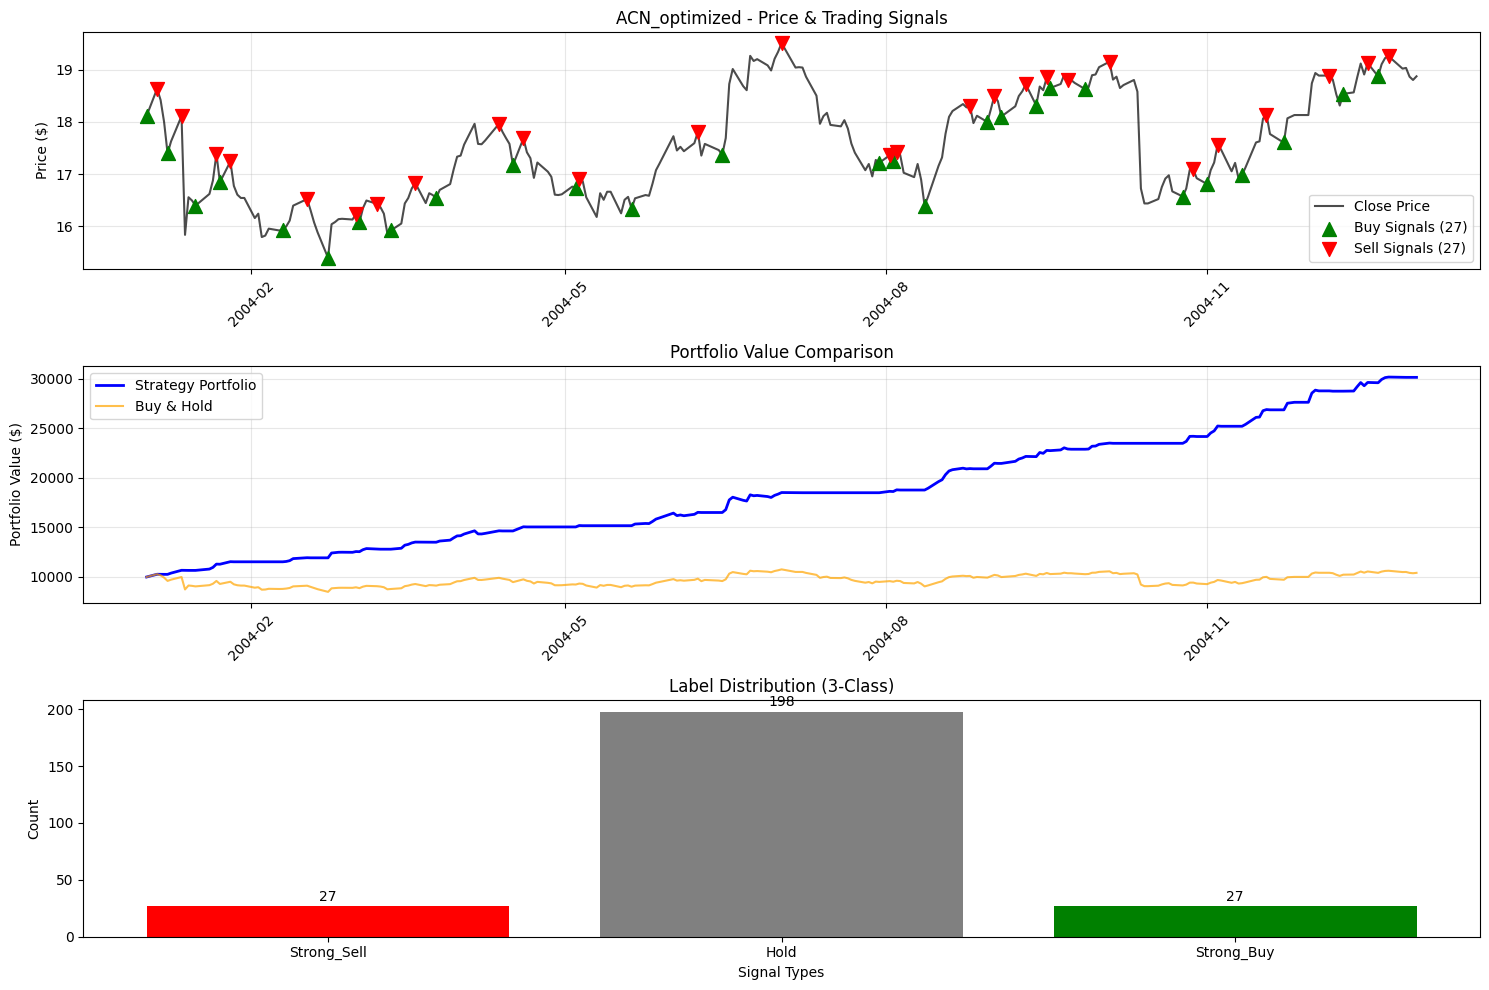


ADBE_optimized 백테스팅 결과:
전략 수익률: 348.85%
Buy & Hold 수익률: 60.69%
초과 수익률: 288.17%
샤프 비율: 7.05
최대 손실폭: -3.19%
총 거래 횟수: 50회
승률: 100.00%
평균 거래수익률: 6.50%
최종 자산: $44,885


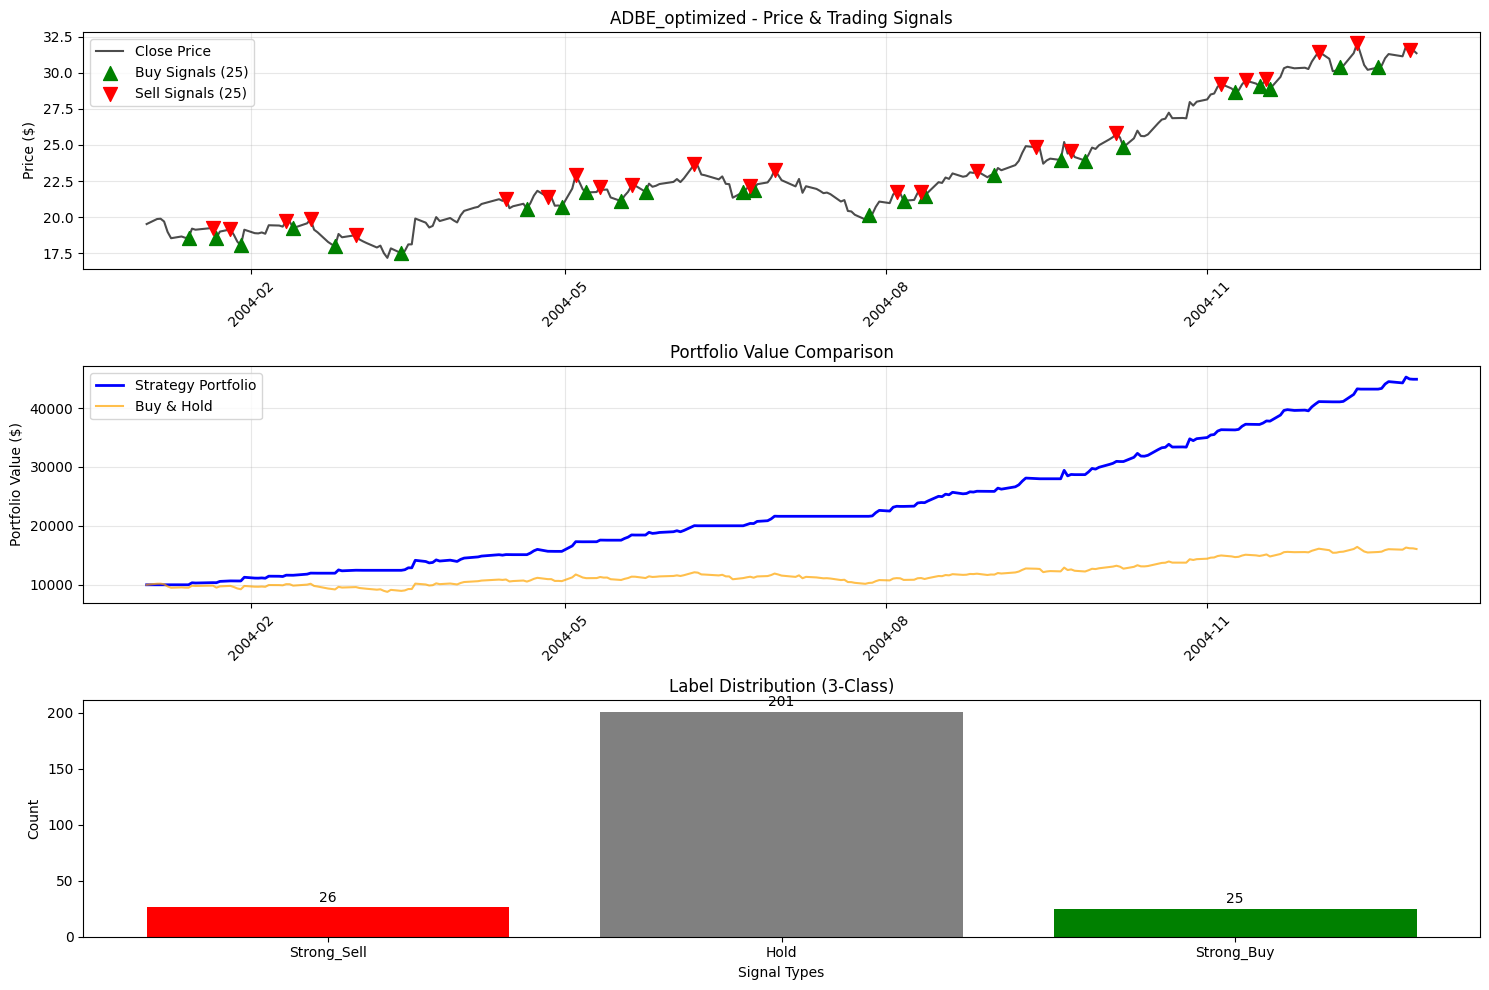


ADI_optimized 백테스팅 결과:
전략 수익률: 228.54%
Buy & Hold 수익률: -18.94%
초과 수익률: 247.47%
샤프 비율: 5.93
최대 손실폭: -4.17%
총 거래 횟수: 38회
승률: 100.00%
평균 거래수익률: 6.72%
최종 자산: $32,854


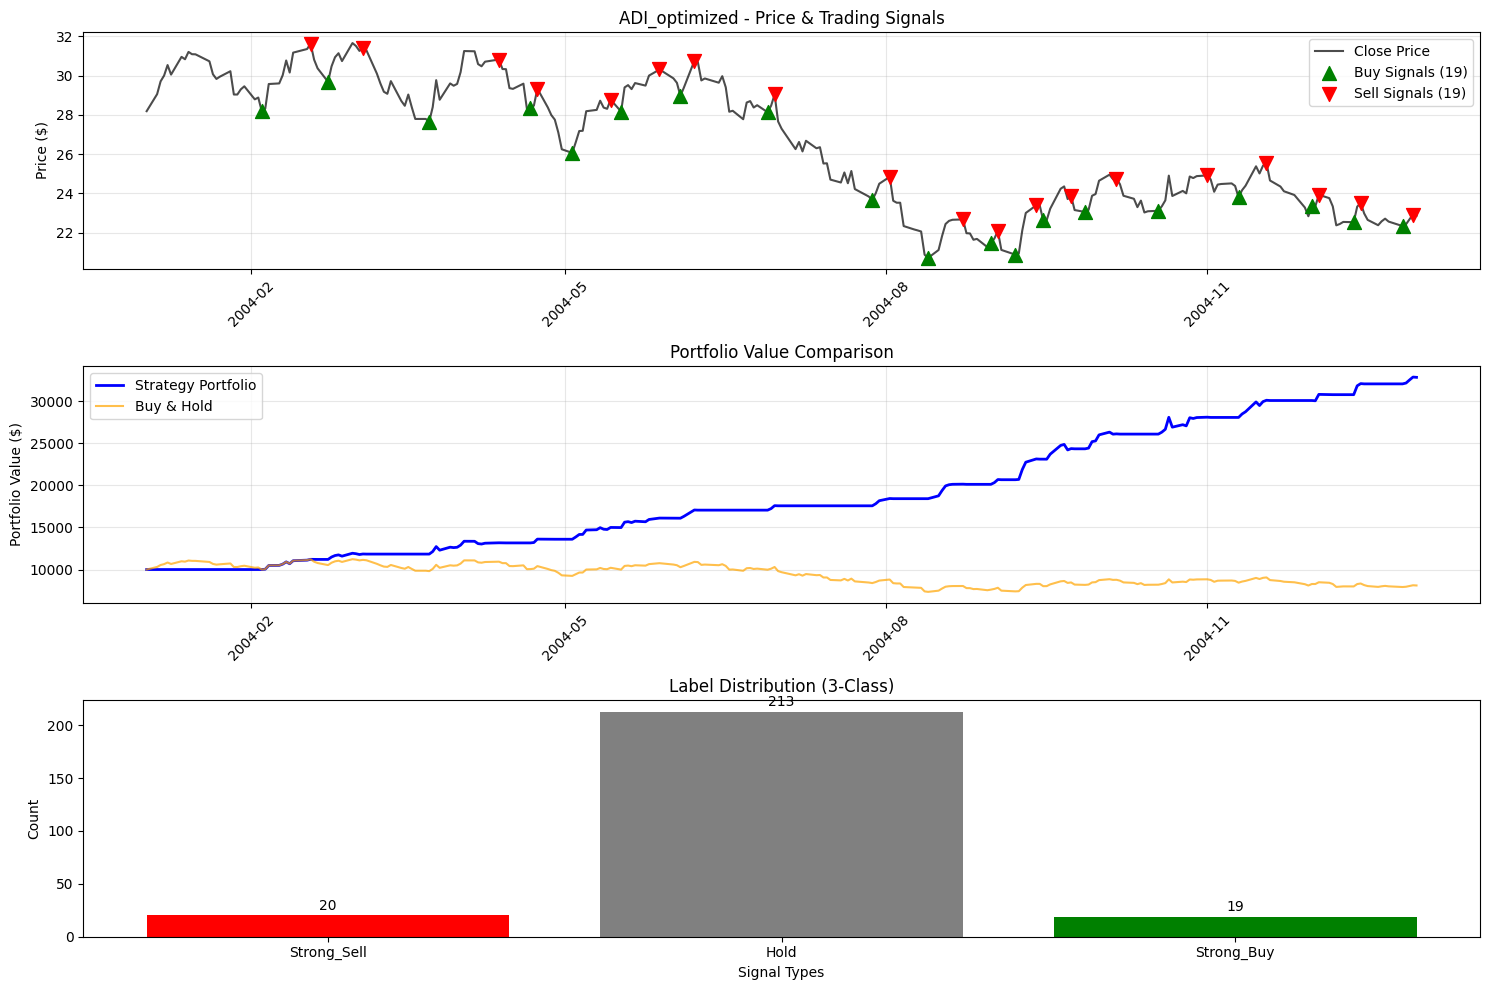


ADP_optimized 백테스팅 결과:
전략 수익률: 130.96%
Buy & Hold 수익률: 12.46%
초과 수익률: 118.50%
샤프 비율: 6.08
최대 손실폭: -2.57%
총 거래 횟수: 42회
승률: 100.00%
평균 거래수익률: 4.33%
최종 자산: $23,096


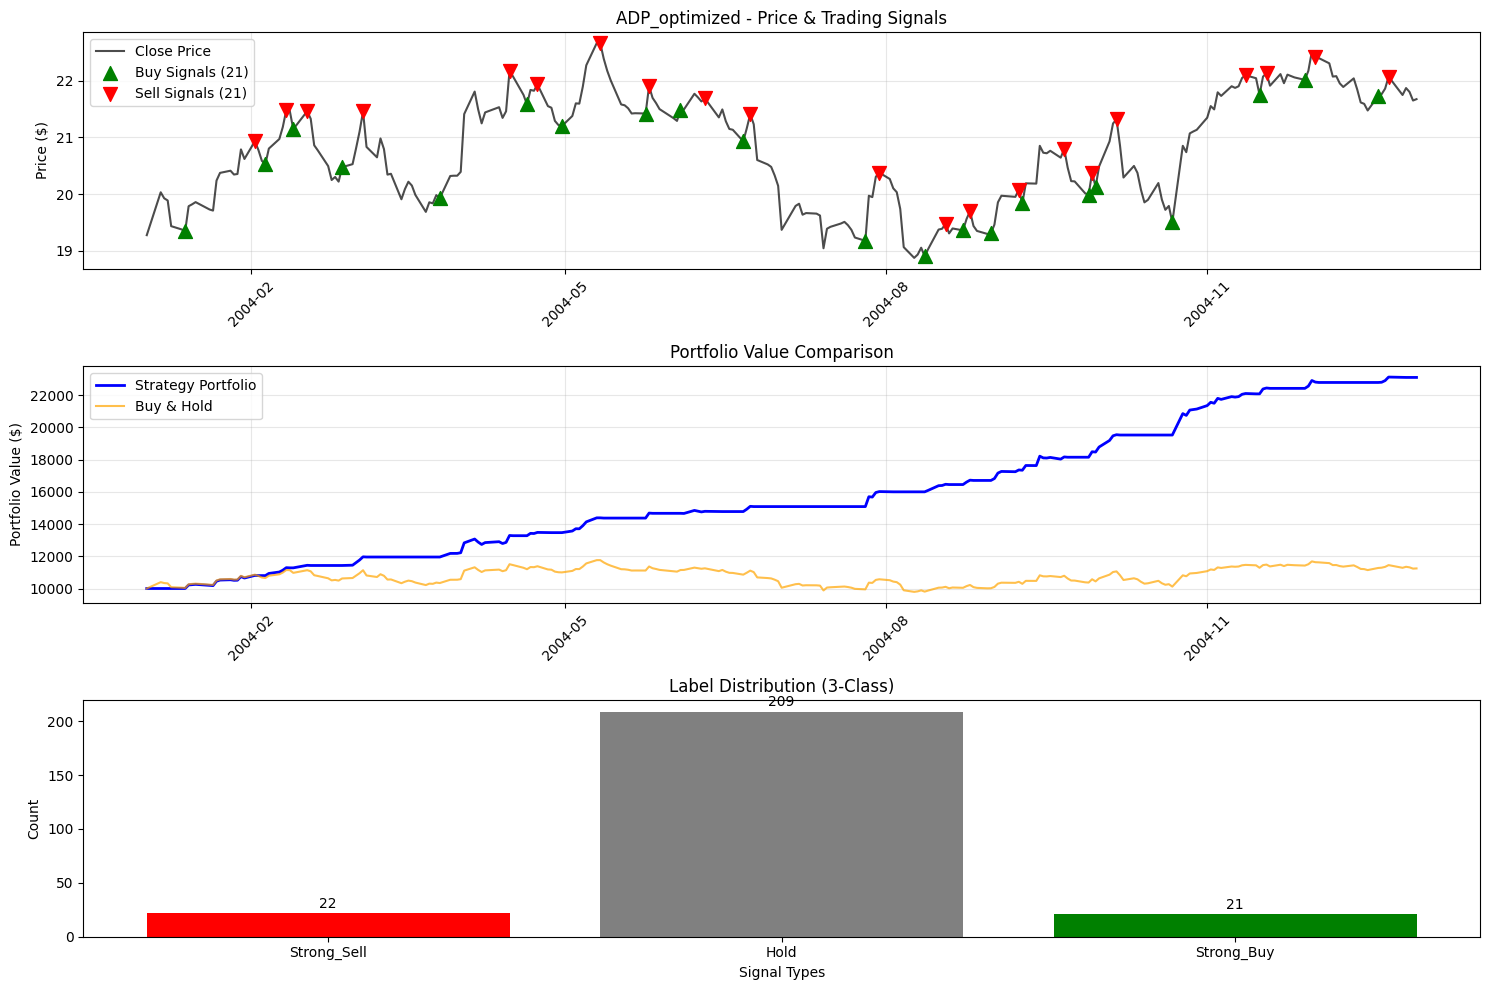


ADSK_optimized 백테스팅 결과:
전략 수익률: 610.47%
Buy & Hold 수익률: 210.63%
초과 수익률: 399.84%
샤프 비율: 7.63
최대 손실폭: -2.30%
총 거래 횟수: 40회
승률: 100.00%
평균 거래수익률: 10.98%
최종 자산: $71,047


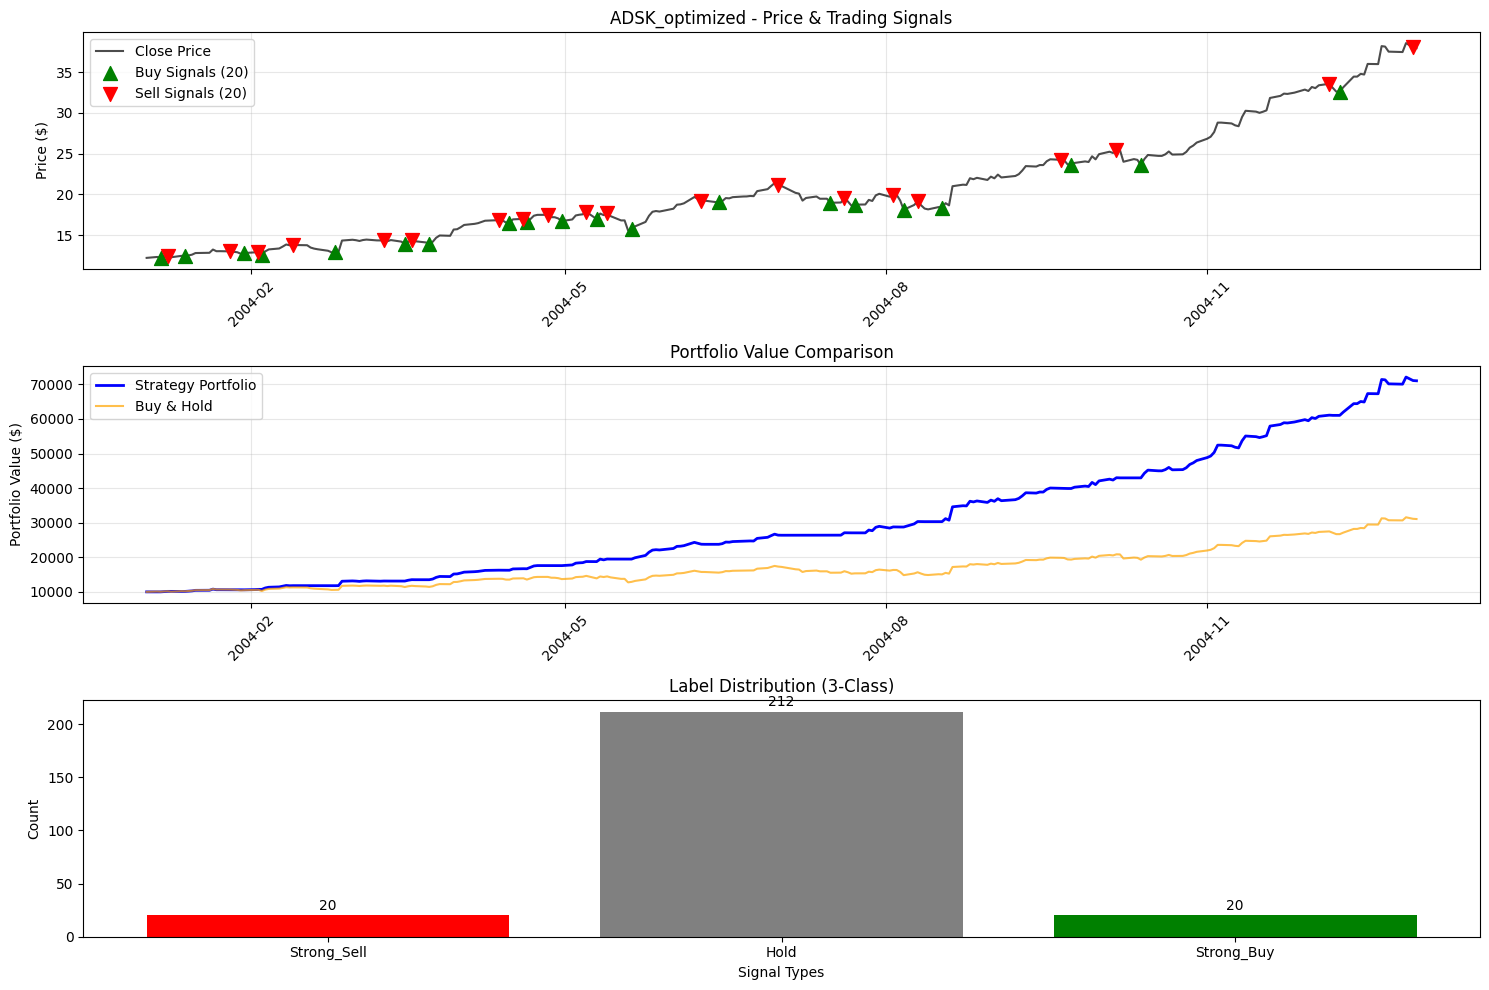


AEP_optimized 백테스팅 결과:
전략 수익률: 106.04%
Buy & Hold 수익률: 16.57%
초과 수익률: 89.47%
샤프 비율: 6.22
최대 손실폭: -1.75%
총 거래 횟수: 38회
승률: 100.00%
평균 거래수익률: 4.13%
최종 자산: $20,604


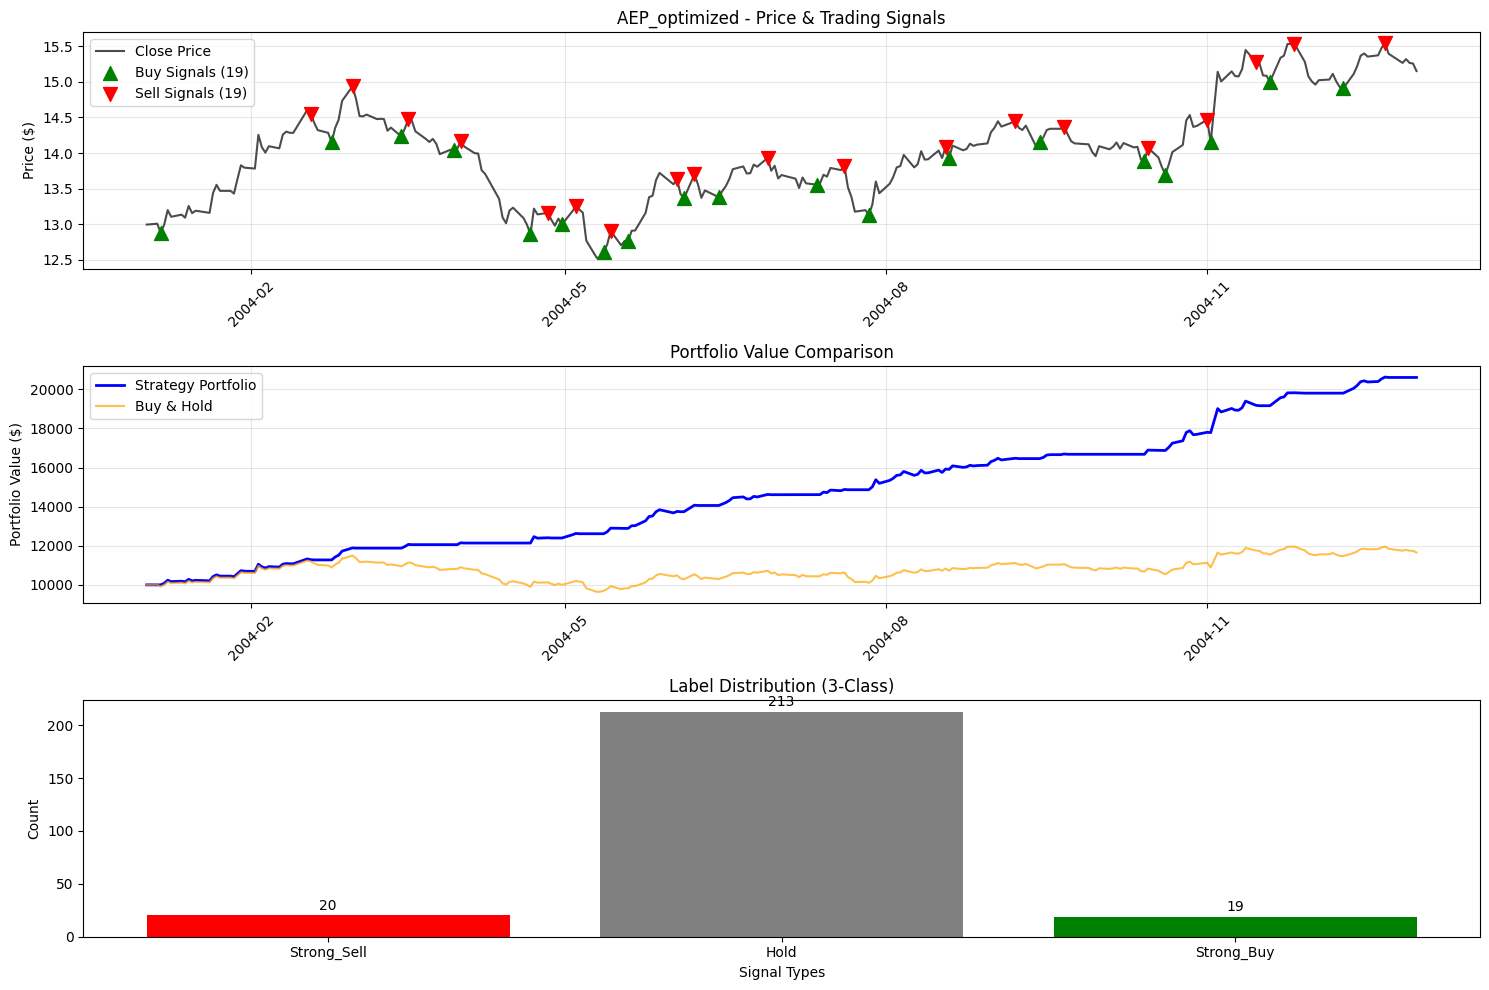


AIG_optimized 백테스팅 결과:
전략 수익률: 100.16%
Buy & Hold 수익률: -1.27%
초과 수익률: 101.43%
샤프 비율: 5.18
최대 손실폭: -1.19%
총 거래 횟수: 32회
승률: 93.75%
평균 거래수익률: 4.70%
최종 자산: $20,016


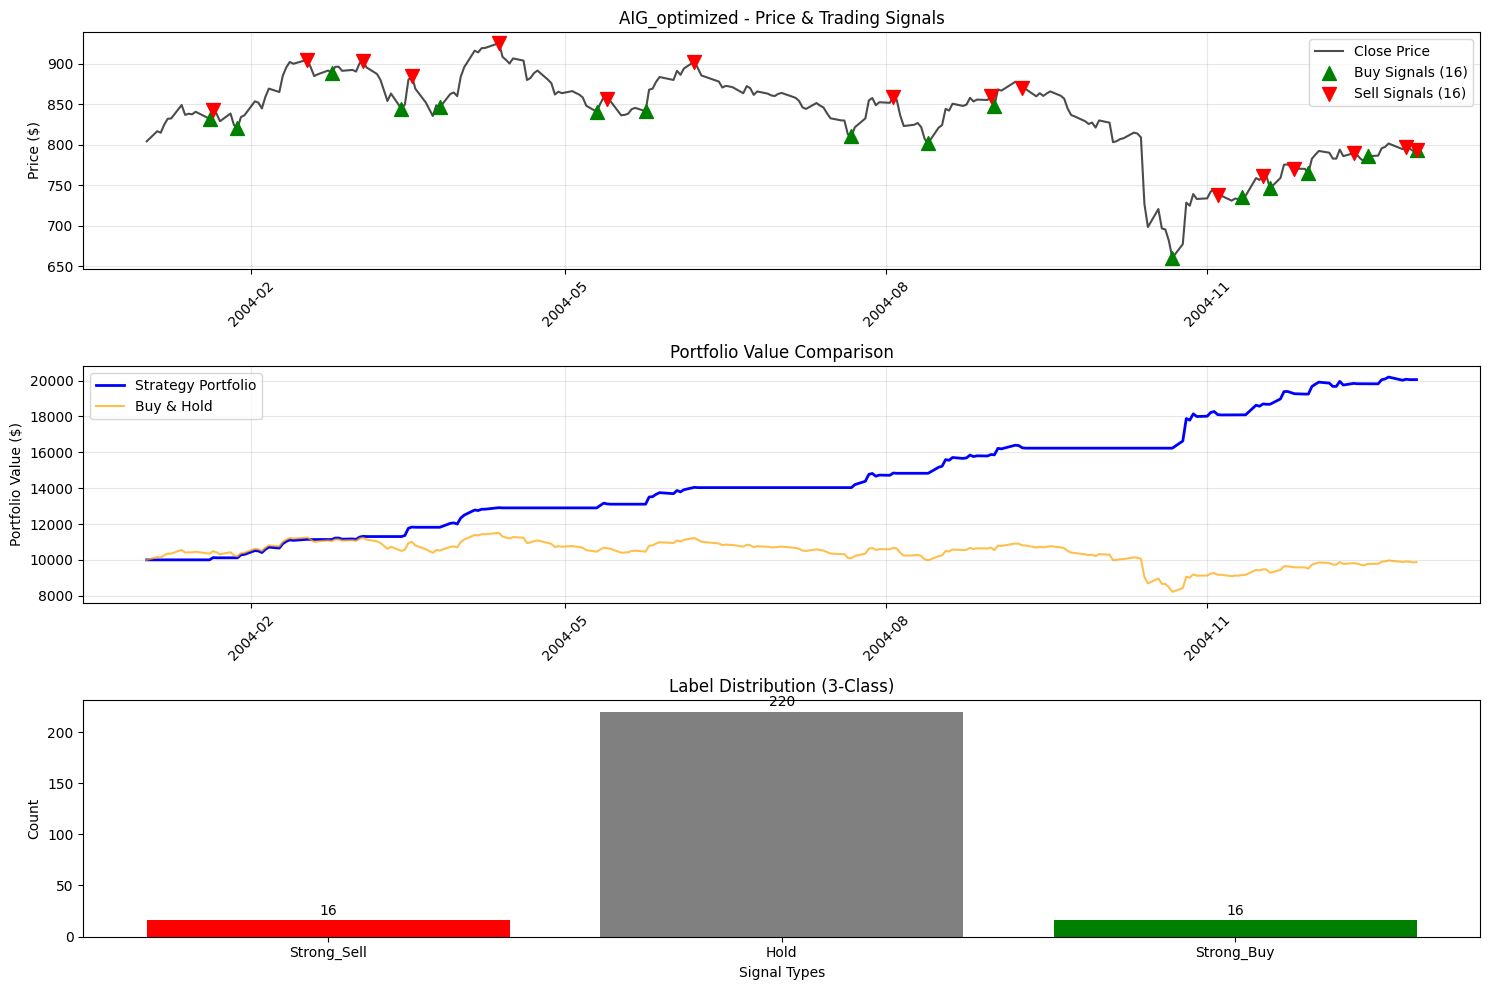


AMAT_optimized 백테스팅 결과:
전략 수익률: 300.10%
Buy & Hold 수익률: -22.62%
초과 수익률: 322.73%
샤프 비율: 6.84
최대 손실폭: -3.74%
총 거래 횟수: 62회
승률: 100.00%
평균 거래수익률: 4.83%
최종 자산: $40,010


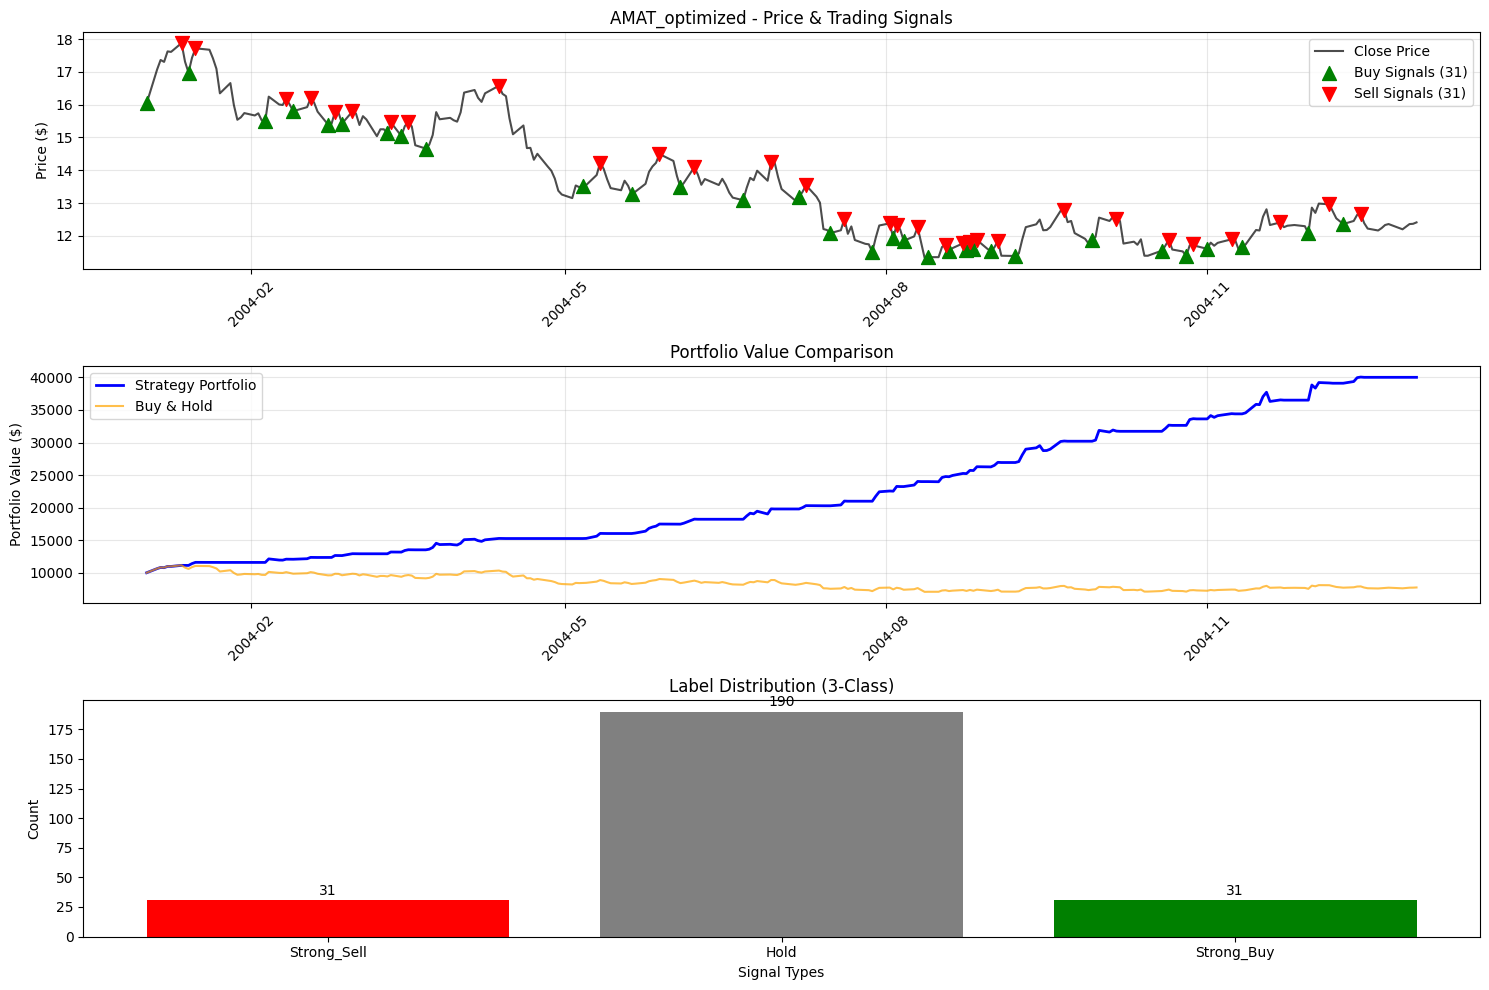


전체 백테스팅 결과 요약:
        Symbol  Total_Return  Excess_Return  Sharpe_Ratio  Win_Rate  Num_Trades
AAPL_optimized         7.202          5.176         6.698     1.000          44
 ABT_optimized         1.375          1.201         5.406     1.000          42
 ACN_optimized         2.014          1.972         7.459     1.000          54
ADBE_optimized         3.489          2.882         7.048     1.000          50
 ADI_optimized         2.285          2.475         5.928     1.000          38
 ADP_optimized         1.310          1.185         6.084     1.000          42
ADSK_optimized         6.105          3.998         7.631     1.000          40
 AEP_optimized         1.060          0.895         6.219     1.000          38
 AIG_optimized         1.002          1.014         5.177     0.938          32
AMAT_optimized         3.001          3.227         6.842     1.000          62

평균 통계:
평균 수익률: 288.42%
평균 초과수익률: 240.25%
평균 샤프비율: 6.45
평균 승률: 99.38%
2004년 백테스팅 완료

전체 연도별 백테스팅 완료

연도별

In [20]:
# 연도별 백테스팅 실행
if __name__ == "__main__":
    
    # 백테스팅할 연도 범위 설정
    start_year = 2003
    end_year = 2004
    
    # 각 연도별 결과 저장
    yearly_results = {}
    
    print("연도별 백테스팅 시작")
    print("=" * 50)
    
    for year in range(start_year, end_year + 1):
        print(f"\n{year}년 백테스팅 실행 중...")
        
        try:
            # 해당 연도 기간 설정
            start_date = f'{year}-01-01'
            end_date = f'{year}-12-31'
            
            # 백테스팅 실행
            backtester = run_individual_backtest(
                data_path=save_path_1,
                start_date=start_date,
                end_date=end_date,
                max_stocks=10,               # 처음 n개 종목만 테스트
                initial_capital=10000
            )
            
            # 해당 연도 결과 저장
            yearly_results[year] = {
                'backtester': backtester,
                'period': f'{start_date} ~ {end_date}'
            }
            
            print(f"{year}년 백테스팅 완료")
            
        except Exception as e:
            print(f"{year}년 백테스팅 실패: {e}")
            yearly_results[year] = None
    
    print("\n" + "=" * 50)
    print("전체 연도별 백테스팅 완료")
    
    # 연도별 결과 요약
    print("\n연도별 결과 요약:")
    for year, result in yearly_results.items():
        if result is not None:
            print(f"{year}년: 성공")
        else:
            print(f"{year}년: 실패")